In [132]:
import numpy as np
import batman
import corner
import argparse
import exomast_api
import joblib
import json
import matplotlib
import matplotlib.pyplot as plt
import os
import pygtc

from datetime import datetime
from functools import partial
from glob import glob
from lmfit import Parameters, Minimizer, report_errors
from multiprocessing import cpu_count, Pool
from os import environ
from pandas import DataFrame
from scipy import special
from scipy import spatial
from statsmodels.robust import scale
from termcolor import colored
from time import time
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

# SKYWALKER methods and assisting routines:
import skywalker
from skywalker import utils
from skywalker import models
from skywalker import bliss
from skywalker import krdata as kr
from skywalker import pld
from skywalker.utils import plot_fit_residuals_physics, plot_physics_only

In [63]:
# Global constants.
y,x = 0,1
ppm = 1e6
day_to_seconds = 86400
zero = 0.0

save_now = True

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fit_type = {True: 'mcmc', False:'mle'}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Load the data

In [64]:
json_dir = environ['HOME'] + '/Research/Planets/PhaseCurves/Qatar2_Results/'
json_planet_file = 'qatar2_planet_params.json'
planet_name = 'qatar2'
mast_name = 'Qatar-2 b'

# method = 'bliss' # BLISS SELF-CALIBRATION SETTING
# method = 'krdata' # KRDATA SELF-CALIBRATION SETTING
method = 'pld'; pld_order = 3 # PLD SELF-CALIBRATION SETTING

fit_function = 'starry'

channel = 'ch2' # CHANNEL SETTING
staticRad = 2.5
varRad = 0.0
base_dir = environ['HOME'] + '/Research/Planets/PhaseCurves/Qatar2_Results/WandererOuput/'
dataDir = base_dir + 'qatar2_full_output_for_pipeline_{}_{:.1f}_{:.1f}.joblib.save'.format(channel, staticRad, varRad)

save_dir = environ['HOME'] + '/Research/Planets/PhaseCurves/Qatar2_Results/Keep_For_Now/'

x_bin_size = 0.01
y_bin_size = 0.01
do_mcmc = False

In [ ]:
planet_info = exomast_api.exoMAST_API(planet_name=mast_name)
planet_info.Rp_Rs = planet_info.Rp_Rs or None # for later
if not hasattr(planet_info, 'Rp_Rs') or planet_info.Rp_Rs is None:
    print('[WARNING] Rp_Rs does not exist in `planet_info`')
    print('Assuming Rp_Rs == sqrt(transit_depth)')
    planet_info.Rp_Rs = np.sqrt(planet_info.transit_depth)

In [67]:
# transit_type='secondary'
x_sigma_range = 4
y_sigma_range = 4
f_sigma_range = 4

# Grab the MCMC Results

In [119]:
from statsmodels.tools.eval_measures import aicc

save_dir = '/Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/'

mcmc_joblib_files = sorted(glob(save_dir + '*mcmc*joblib*'))

time_stamps = {}

x_bin_size = 0.01
y_bin_size = 0.01

x_sigma_range = 4
y_sigma_range = 4
f_sigma_range = 4

staticRad = 2.5
varRad = 0.0
base_dir = os.environ['HOME'] + '/Research/Planets/PhaseCurves/'

data_dir_template = base_dir +'/Qatar2_Results/WandererOuput/qatar2_full_output_for_pipeline_{}_{}_{}.joblib.save'

fluxes = {}
times = {}
flux_errs = {}
npix = {}
xcenters = {}
ycenters = {}
xwidths = {}
ywidths = {}
knots = {}
nearIndices = {}
ind_kdtree = {}
gw_kdtree = {}
pld_intensities0 = {}
keep_inds = {}

for fname in mcmc_joblib_files:
    save_name = fname.split('/')[-1]
    planet_name = save_name.split('_')[0]
    method = fname.split('_mcmc_')[0].split('_')[-1]
    channel = 'ch{}'.format(fname.split('{}_ch'.format(planet_name))[1].split('_')[0])
    staticRad = fname.split(channel+'_')[1].split('_')[0]
    varRad = fname.split(staticRad+'_')[1].split('_')[0]
    n_steps = fname.split('steps')[0].split('_')[-1]
    n_walkers = fname.split('walkers')[0].split('_')[-1]
    time_stamp = fname.split('.joblib.')[0].split('_')[-1]
    
    if channel not in time_stamps.keys(): time_stamps[channel] = {}
    if channel not in fluxes.keys(): fluxes[channel] = {}
    if channel not in times.keys(): times[channel] = {}
    if channel not in flux_errs.keys(): flux_errs[channel] = {}
    if channel not in npix.keys(): npix[channel] = {}
    if channel not in xcenters.keys(): xcenters[channel] = {}
    if channel not in ycenters.keys(): ycenters[channel] = {}
    if channel not in xwidths.keys(): xwidths[channel] = {}
    if channel not in ywidths.keys(): ywidths[channel] = {}
    if channel not in knots.keys(): knots[channel] = {}
    if channel not in nearIndices.keys(): nearIndices[channel] = {}
    if channel not in ind_kdtree.keys(): ind_kdtree[channel] = {}
    if channel not in gw_kdtree.keys(): gw_kdtree[channel] = {}
    if channel not in pld_intensities0.keys(): pld_intensities0[channel] = {}
    if channel not in keep_inds.keys(): keep_inds[channel] = {}
    
    if method not in knots[channel].keys(): knots[channel][method] = {}
    if method not in nearIndices[channel].keys(): knots[channel][method] = {}
    if method not in ind_kdtree[channel].keys(): ind_kdtree[channel][method] = {}
    if method not in pld_intensities0[channel].keys(): pld_intensities0[channel][method] = {}
    if method not in gw_kdtree[channel].keys(): gw_kdtree[channel][method] = {}
    
    print('[INFO] Loading File: {}'.format(fname))
    mcmc_result = joblib.load(fname)
    
    print('Acquiring Data')
    dataDir_ = data_dir_template.format(channel, staticRad, varRad)
    data_in = utils.setup_inputs_from_file(dataDir_, x_bin_size=x_bin_size, y_bin_size=y_bin_size, xSigmaRange=x_sigma_range, 
                                           ySigmaRange=y_sigma_range, fSigmaRange=f_sigma_range, flux_key='phots', 
                                           time_key='times', flux_err_key='noise', eff_width_key = 'npix', 
                                           pld_coeff_key = 'pld', ycenter_key='ycenters', xcenter_key='xcenters', 
                                           ywidth_key='ywidths', xwidth_key='xwidths', method=method)

    fluxes_, times_, flux_errs_, npix_, pld_intensities0_, xcenters_, ycenters_, xwidths_, ywidths_, \
        knots_, nearIndices_, keep_inds_, ind_kdtree_, gw_kdtree_ = data_in
    
    # Only use the valid values
    times[channel] = times_[keep_inds_]
    fluxes[channel] = fluxes_[keep_inds_]
    flux_errs[channel] = flux_errs_[keep_inds_]
    npix[channel] = npix_[keep_inds_]
    xcenters[channel] = xcenters_[keep_inds_]
    ycenters[channel] = ycenters_[keep_inds_]
    xwidths[channel] = xwidths_[keep_inds_]
    ywidths[channel] = ywidths_[keep_inds_]
    keep_inds[channel] = keep_inds_, 
    knots[channel][method] = knots_  # [keep_inds_]
    
    if nearIndices_ is not None:
        nearIndices[channel][method] = nearIndices_[keep_inds_]
    else:
        nearIndices[channel][method] = None
    
    if ind_kdtree_ is not None:    
        ind_kdtree[channel][method] = ind_kdtree_[keep_inds_]
    else:
        ind_kdtree[channel][method] = None
    
    if pld_intensities0_ is not None:
        pld_intensities0[channel][method] = pld_intensities0_.T[keep_inds_].T
    else:
        pld_intensities0[channel][method] = None
    
    if gw_kdtree_ is not None:
        gw_kdtree[channel][method] = gw_kdtree_[keep_inds_]
    else:
        gw_kdtree[channel][method] = None
    
    ''' Finsihed Data Acquisition '''
    
    # Normalize fluxes and flux errors around 1
    flux_errs[channel] = flux_errs[channel] / np.median(fluxes[channel])
    fluxes[channel] = fluxes[channel] / np.median(fluxes[channel])

[INFO] Loading File: /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_bliss_mcmc_1000steps_100walkers_20190517135006.joblib.save
Acquiring Data
Setting up inputs for bliss.
Setting up BLISS
BLISS will use a total of 2482 knots
[INFO] Loading File: /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_krdata_mcmc_1000steps_100walkers_20190517144928.joblib.save
Acquiring Data
Setting up inputs for krdata.
Setting up KRDATA
[INFO] Loading File: /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_pld_mcmc_1000steps_1000walkers_20190522074856.joblib.save
Acquiring Data
Setting up inputs for pld.
Using PLD
[INFO] Loading File: /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch2_2.5_0.0_bliss_mcmc_1000steps_100walkers_20190517144929.joblib.save
Acquiring Data
Setting up input

# Modify the PLD components

In [120]:
print("Computing PLD Vectors")
pld_order = 3
add_unity = True
n_ppm = 1.0
verbose = False
do_pca = True
do_ica = False
do_std = True
pca_cut = True
start_unity = False

pld_intensities = {}
for fname in mcmc_joblib_files:
    save_name = fname.split('/')[-1]
    planet_name = save_name.split('_')[0]
    method = fname.split('_mcmc_')[0].split('_')[-1]
    channel = 'ch{}'.format(fname.split('{}_ch'.format(planet_name))[1].split('_')[0])
    staticRad = fname.split(channel+'_')[1].split('_')[0]
    varRad = fname.split(staticRad+'_')[1].split('_')[0]
    n_steps = fname.split('steps')[0].split('_')[-1]
    n_walkers = fname.split('walkers')[0].split('_')[-1]
    time_stamp = fname.split('.joblib.')[0].split('_')[-1]

    if channel not in pld_intensities.keys(): pld_intensities[channel] = {}
    
    mcmc_result = joblib.load(fname)
    
    print(channel, method)
    if method in ['bliss', 'krdata']:
        pld_intensities[channel][method] = None
    else:
        pldints = [pld_now[keep_inds[channel]] for pld_now in pld_intensities0[channel][method]]
        pld_intensities[channel][method] = pld.normalize_pld(np.array(pldints))

        n_pld, _ = pld_intensities0[channel][method].shape

        max_n_pld = n_pld*pld_order
        full_pld_keys = ['pld{}'.format(k) for k in range(max_n_pld)] + ['pldBase']

        pld_intensities[channel][method] = models.compute_pld_vectors(fluxes[channel], pld_intensities=pld_intensities0[channel][method], 
                                                               add_unity=add_unity, n_pld=n_pld, n_ppm=n_ppm, order=pld_order, 
                                                               verbose=verbose, do_pca=do_pca, do_ica=do_ica, do_std=do_std, 
                                                               pca_cut=False, start_unity=start_unity)

        pld_intensities[channel][method] = DataFrame(pld_intensities[channel][method].T, columns = full_pld_keys)

        pld_keys_used = [key for key in mcmc_result.params.keys() if 'pld' in key.lower()]
        pld_intensities[channel][method] = pld_intensities[channel][method][pld_keys_used].values.T

Computing PLD Vectors
ch1 bliss
ch1 krdata
ch1 pld
ch2 bliss
ch2 krdata
ch2 pld


# Organize MCMC Stack and Computer AICc's

In [122]:
mcmc_stack = {}
aic_timestamps = {}

for fname in mcmc_joblib_files:
    save_name = fname.split('/')[-1]
    planet_name = save_name.split('_')[0]
    method = fname.split('_mcmc_')[0].split('_')[-1]
    channel = 'ch{}'.format(fname.split('{}_ch'.format(planet_name))[1].split('_')[0])
    staticRad = fname.split(channel+'_')[1].split('_')[0]
    varRad = fname.split(staticRad+'_')[1].split('_')[0]
    n_steps = fname.split('steps')[0].split('_')[-1]
    n_walkers = fname.split('walkers')[0].split('_')[-1]
    time_stamp = fname.split('.joblib.')[0].split('_')[-1]
    
    if channel not in mcmc_stack.keys(): mcmc_stack[channel] = {}
    if channel not in aic_timestamps.keys(): aic_timestamps[channel] = {}
    
    mcmc_result = joblib.load(fname)
    
    lmax = 1
    star, planet, system = skywalker.instantiate_system(planet_info, lmax = lmax)
    partial_residuals  = partial(skywalker.residuals_func,
                                 times = times[channel], 
                                 xcenters = xcenters[channel], 
                                 ycenters = ycenters[channel], 
                                 fluxes = fluxes[channel], 
                                 flux_errs = flux_errs[channel], 
                                 knots = knots[channel][method], 
                                 nearIndices = nearIndices[channel][method], 
                                 keep_inds = keep_inds[channel], 
                                 ind_kdtree = ind_kdtree[channel][method], 
                                 pld_intensities = pld_intensities[channel][method], 
                                 gw_kdtree = gw_kdtree[channel][method], 
                                 planet_info = planet_info,
                                 method = method.lower(),
                                 x_bin_size = x_bin_size,
                                 y_bin_size = y_bin_size, 
                                 include_transit = True, 
                                 include_eclipse = True, 
                                 include_phase_curve = True, 
                                 include_polynomial = True,
                                 fit_function = fit_function,
                                 star = star, 
                                 planet = planet, 
                                 system = system,
                                 interpolate = False,
                                 interp_ratio = 0.1,
                                 eclipse_option = 'starry')

    def logprior_func(p):
        for key, val in p.items():
            # Uniform Prior
            if val.min >= val.value >= val.max: return -np.inf

        # Establish that the limb darkening parameters 
        #  cannot sum to 1 or greater
        #  Kipping et al 201? and Espinoza et al 201?
        if 'u1' in p.keys() and 'u2' in p.keys():
            if p['u1'] + p['u2'] >= 1: return -np.inf

        return 0
    
    def lnprob(p):
        logprior = logprior_func(p)
        if not np.isfinite(logprior):
            return -np.inf

        resid = partial_residuals(p)

        s = p['err_mod']
        resid *= 1 / s
        resid *= resid
        resid += np.log(2 * np.pi * s**2)

        return -0.5 * np.sum(resid) + logprior
    
    # if method not in time_stamps[channel].keys(): time_stamps[channel][method] = time_stamp
    # try:
    llf = lnprob(mcmc_result.params)
    df_modelwc = sum([deleteme.vary for deleteme in mcmc_result.params.values()])
    nobs = times[channel].size

    aic_timestamp = aicc(llf, nobs, df_modelwc)
    # aic_timestamp = -2. * llf + 2. * df_modelwc * nobs / (nobs - df_modelwc - 1.)

    if method not in aic_timestamps[channel].keys(): 
        aic_timestamps[channel][method] = aic_timestamp

    if aic_timestamp <= aic_timestamps[channel][method]:
        time_stamps[channel][method] = time_stamp
        aic_timestamps[channel][method] = aic_timestamp

        if 'pca' in fname: method = 'pca_' + method

        print('Loading {} {} {} {} {} {} {} {} with AIC {}'.format(planet_name, method, channel, staticRad, varRad, n_steps, n_walkers, time_stamp, aic_timestamp))
        mcmc_stack[channel][method] = mcmc_result
    # except Exception as e:
    #     print('Error', str(e))

Loading qatar2 bliss ch1 2.5 0.0 1000 100 20190517135006 with AIC 226524.2939686758
Loading qatar2 krdata ch1 2.5 0.0 1000 100 20190517144928 with AIC 226181.02338200784
Loading qatar2 pld ch1 2.5 0.0 1000 1000 20190522074856 with AIC 244128.7206957271
Loading qatar2 bliss ch2 2.5 0.0 1000 100 20190517144929 with AIC 220493.82300513238
Loading qatar2 krdata ch2 2.5 0.0 1000 100 20190517144534 with AIC 219991.5201073861
Loading qatar2 pld ch2 2.5 0.0 1000 1000 20190522081610 with AIC 219595.2342481692


In [123]:
for channel in aic_timestamps.keys():
    for method in aic_timestamps[channel].keys():
        print(channel, method, aic_timestamps[channel][method])

ch1 bliss 226524.2939686758
ch1 krdata 226181.02338200784
ch1 pld 244128.7206957271
ch2 bliss 220493.82300513238
ch2 krdata 219991.5201073861
ch2 pld 219595.2342481692


In [124]:
# columns_print = ['deltaTc', 'tdepth', 'edepth', 'u1', 'cosAmp', 'cosPhase', 'night_flux','slope', 'err_mod']
columns_print = ['deltaTc', 'tdepth', 'edepth', 'u1', 'Y_1n1', 'Y_1_0', 'Y_1p1', 'slope', 'err_mod']

for channel in ['ch1', 'ch2']:
    thingies = [val.flatchain[columns_print] for val in mcmc_stack[channel].values()]
    
#     for thingy in thingies: thingy['cosAmp'] = thingy['cosAmp']*ppm
#     for thingy in thingies: thingy['night_flux'] = thingy['night_flux']*ppm
#     for thingy in thingies: thingy['edepth'] = thingy['cosAmp']*np.cos(thingy['cosPhase']) + thingy['night_flux']
    print()
    print(colored(channel.upper(), 'red'))
    for method, thingy in zip(mcmc_stack[channel].keys(), thingies):
        print()
        print(colored(method.upper(), 'blue'))
        for col in columns_plot:
            print('{:10}:{:.2f} +\- {:.0f} ppm'.format(col, thingy[col].mean()*ppm, thingy[col].std()*ppm))
#         print('Night Flux:   {:.0f} +\- {:.0f} ppm'.format(thingy['night_flux'].mean(), thingy['night_flux'].std()))
#         print('Cos Amp:      {:.0f} +\- {:.0f} ppm'.format(thingy['cosAmp'].mean(), thingy['cosAmp'].std()))
#         print('Edepth:       {:.0f} +\- {:.0f} ppm'.format(thingy['edepth'].mean(), thingy['edepth'].std()))
#         print('Cos Phase:    {:.2f} +\- {:.2f} hours'.format(thingy['cosPhase'].mean()*24, thingy['cosPhase'].std()*24))
        
#         d2n = thingy['cosAmp']*np.cos(thingy['cosPhase']) / (thingy['cosAmp'] + thingy['night_flux'])
#         print('D2N Contrast: {:.2f} +\- {:.2f}'.format(d2n.mean(), d2n.std()))


CH1

BLISS
deltaTc   :-2546.68 +\- 111 ppm
tdepth    :27132.92 +\- 229 ppm
edepth    :1832.28 +\- 159 ppm
u1        :107645.20 +\- 31256 ppm
Y_1n1     :11978.81 +\- 48409 ppm
Y_1_0     :305426.59 +\- 61320 ppm
Y_1p1     :-40726.78 +\- 408864 ppm
slope     :1504.53 +\- 260 ppm
err_mod   :1290536.62 +\- 3556 ppm

KRDATA
deltaTc   :-2515.00 +\- 108 ppm
tdepth    :26984.55 +\- 230 ppm
edepth    :1669.21 +\- 161 ppm
u1        :102849.76 +\- 31209 ppm
Y_1n1     :-29436.92 +\- 54421 ppm
Y_1_0     :392490.13 +\- 73347 ppm
Y_1p1     :-107583.41 +\- 446180 ppm
slope     :1194.96 +\- 258 ppm
err_mod   :1287150.51 +\- 3529 ppm

PLD
deltaTc   :-2785.82 +\- 116 ppm
tdepth    :22604.41 +\- 607 ppm
edepth    :1070.97 +\- 44 ppm
u1        :260449.40 +\- 5190 ppm
Y_1n1     :4918911.24 +\- 135995 ppm
Y_1_0     :1615247.33 +\- 41624 ppm
Y_1p1     :-3041029.84 +\- 262847 ppm
slope     :-6545.05 +\- 124 ppm
err_mod   :1466064.73 +\- 12713 ppm

CH2

BLISS
deltaTc   :-2298.15 +\- 149 ppm
tdepth    :26452.62 

In [125]:
for val in mcmc_stack[channel].values():
    print(val.flatchain.columns)

Index(['deltaTc', 'tdepth', 'edepth', 'u1', 'Y_1n1', 'Y_1_0', 'Y_1p1', 'slope',
       'err_mod'],
      dtype='object')
Index(['deltaTc', 'tdepth', 'edepth', 'u1', 'Y_1n1', 'Y_1_0', 'Y_1p1', 'slope',
       'err_mod'],
      dtype='object')
Index(['deltaTc', 'tdepth', 'edepth', 'u1', 'Y_1n1', 'Y_1_0', 'Y_1p1', 'slope',
       'pld0', 'pld1', 'pld2', 'pld3', 'pld4', 'pld5', 'pld6', 'pld7', 'pld8',
       'pld9', 'pld10', 'pld11', 'pld12', 'pld13', 'pld14', 'pld15', 'pld16',
       'pld17', 'pld18', 'pld19', 'pld20', 'pld21', 'pldBase', 'err_mod'],
      dtype='object')


Saving PyGTC ch1 to qatar2_ch1_2.5_0.0_all3_mcmc_pygtc_combo_cornerplot.png
Saving PyGTC ch2 to qatar2_ch2_2.5_0.0_all3_mcmc_pygtc_combo_cornerplot.png


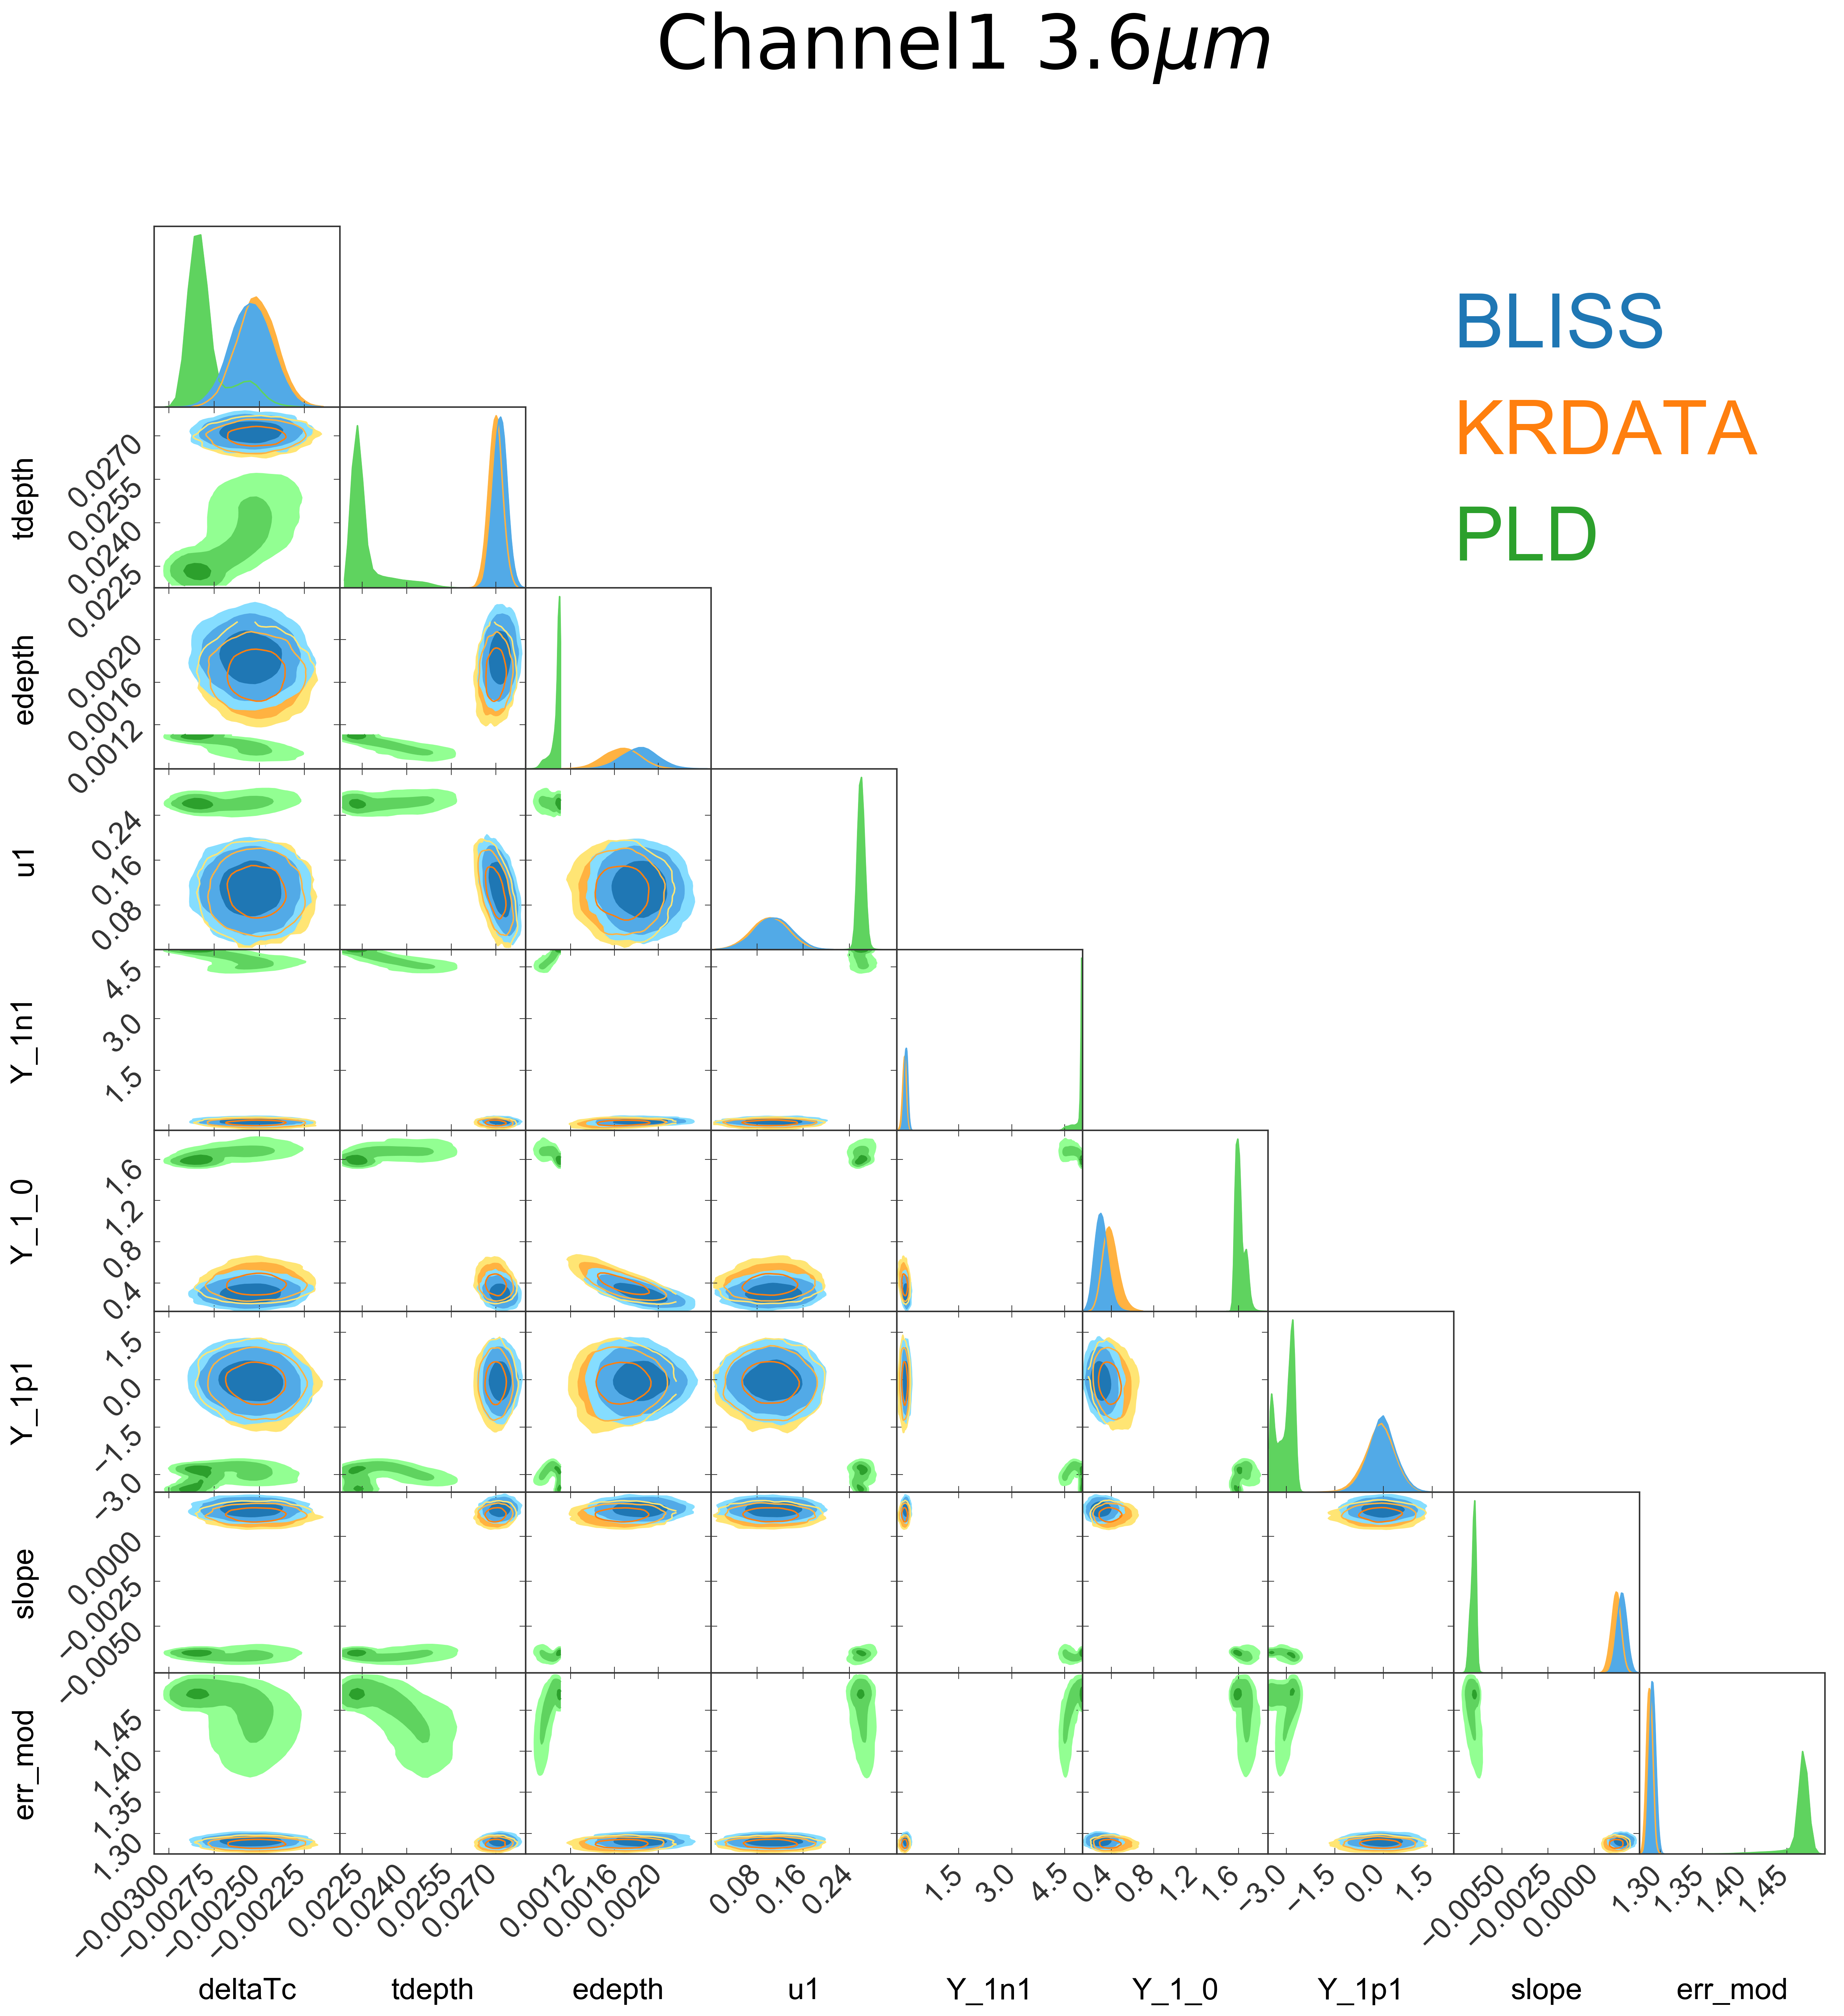

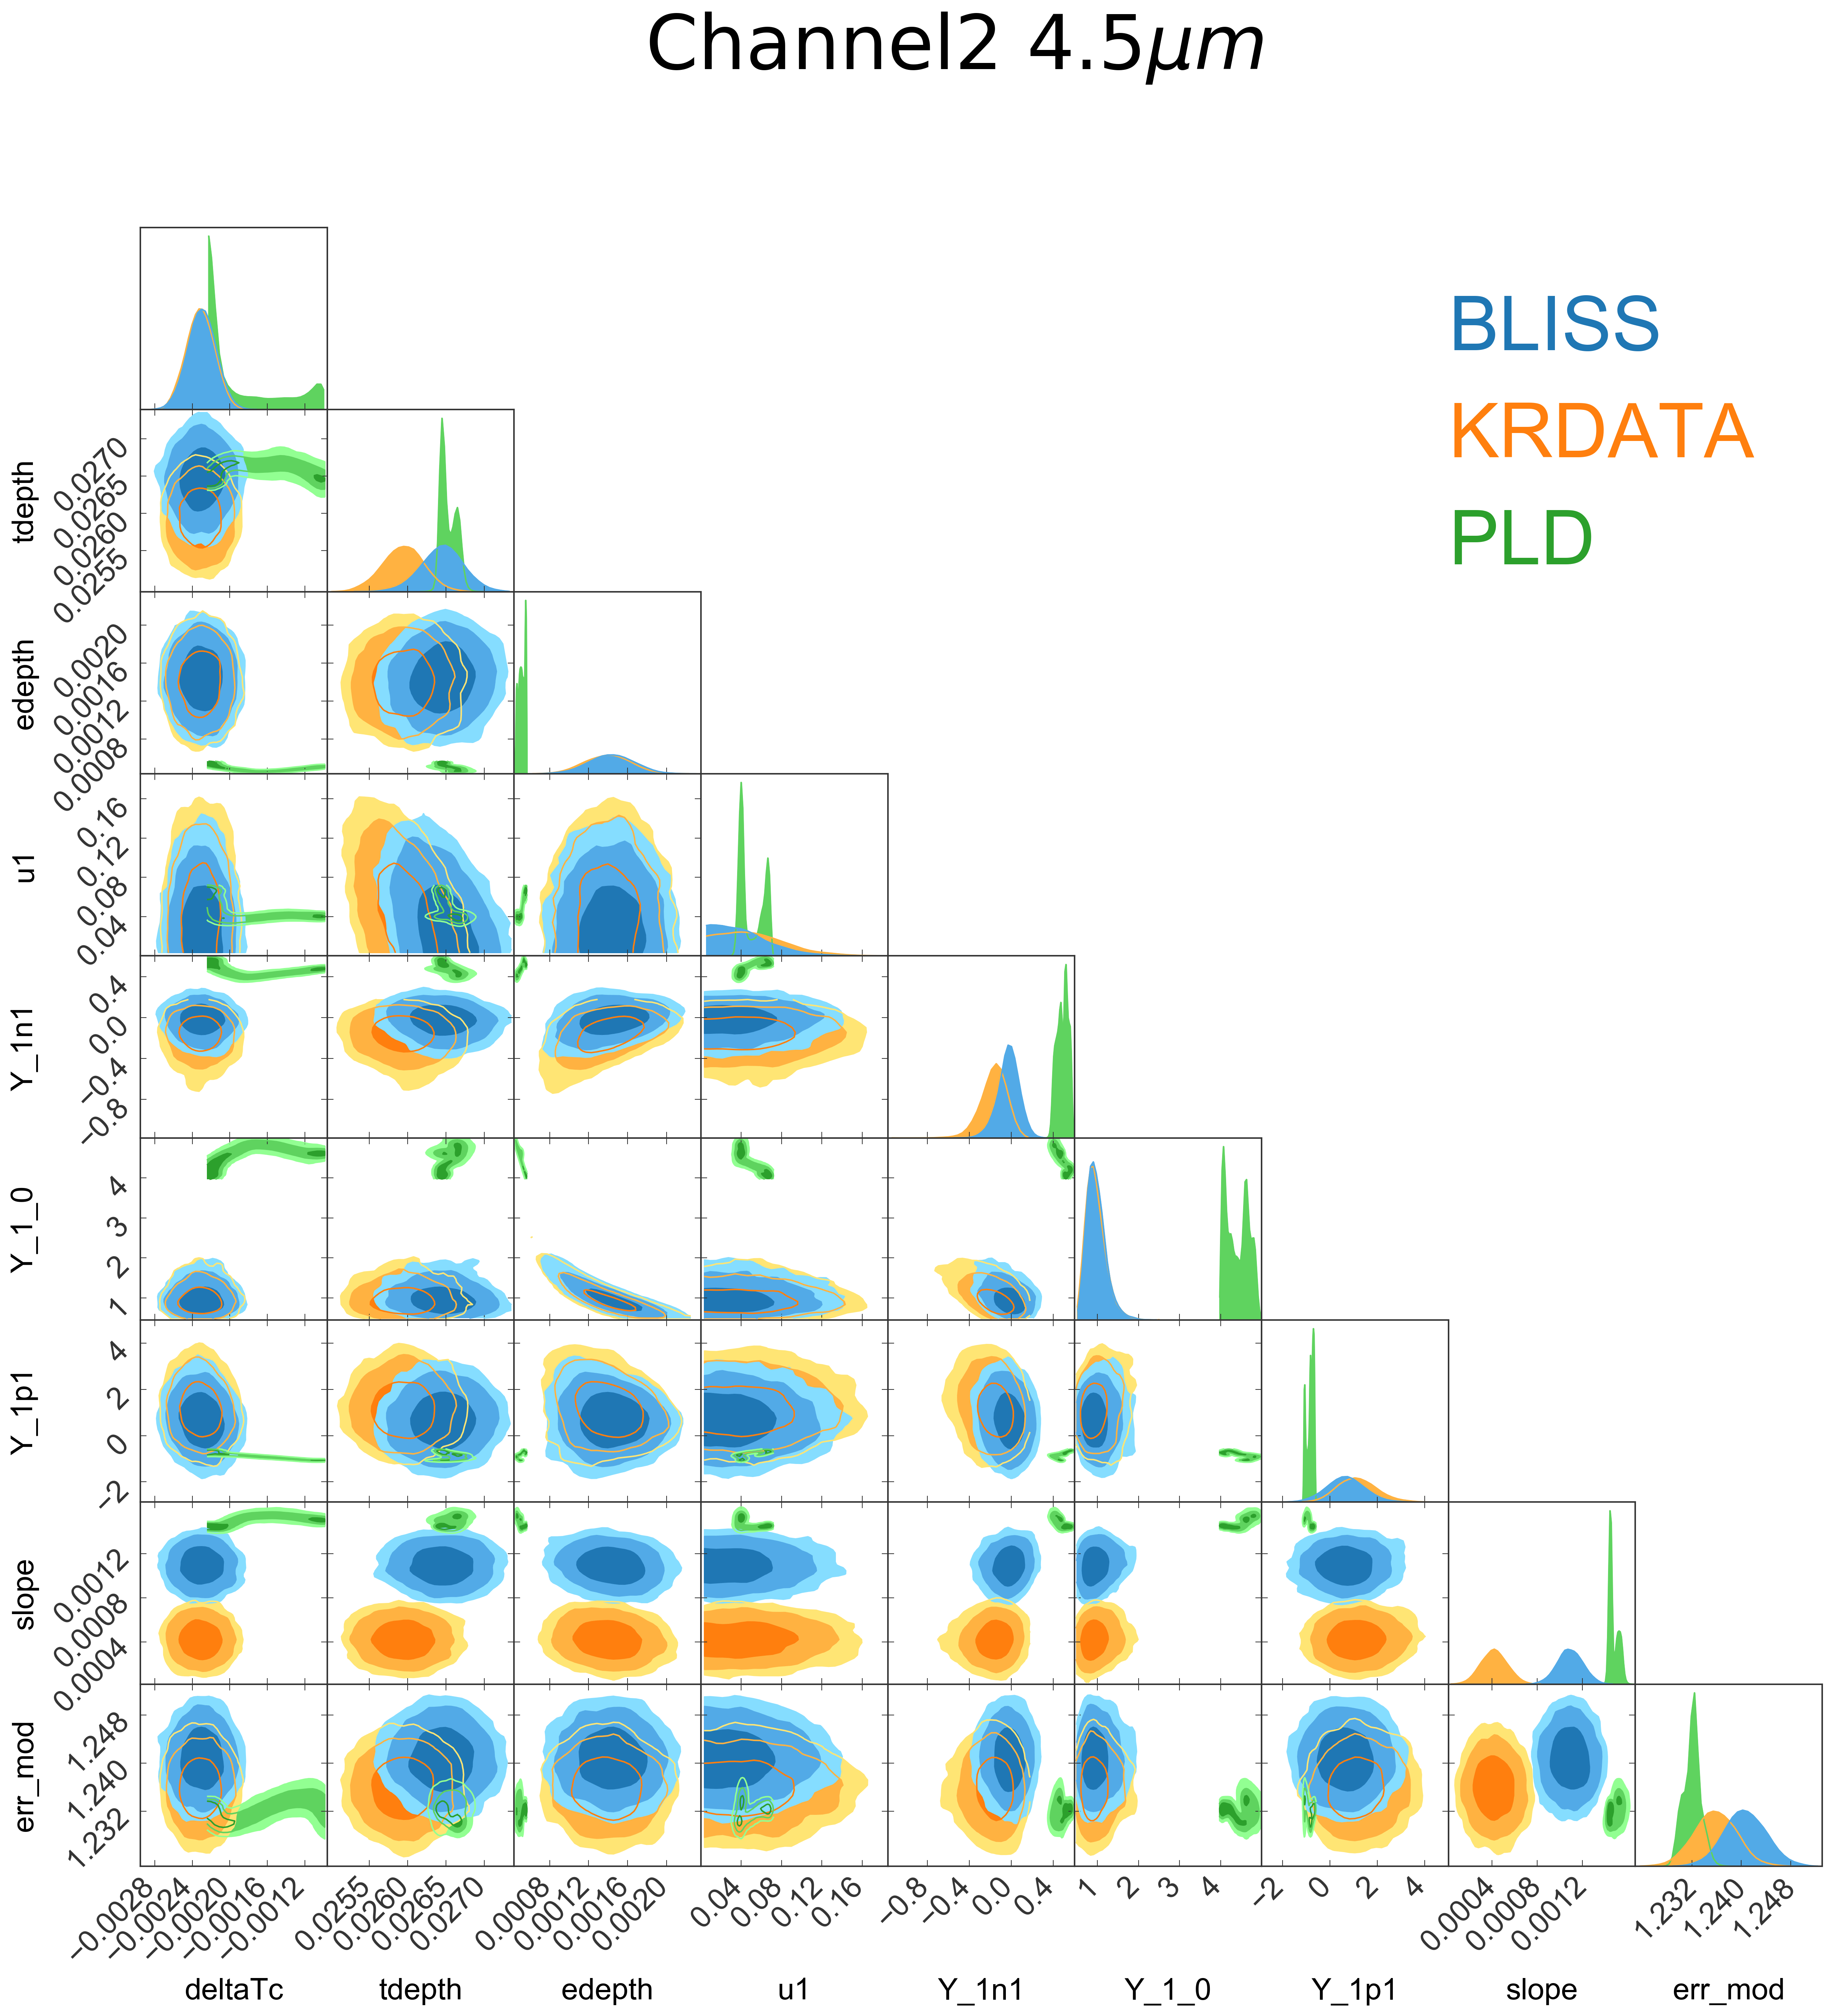

In [126]:
titles = {'ch1':'Channel1 3.6$\mu m$', 'ch2':'Channel2 4.5$\mu m$'}

# columns_plot = ['deltaTc', 'tdepth', 'edepth', 'u1', 'cosAmp', 'cosPhase', 'night_flux','slope', 'err_mod']
columns_plot = ['deltaTc', 'tdepth', 'edepth', 'u1', 'Y_1n1', 'Y_1_0', 'Y_1p1', 'slope', 'err_mod']

colorsOrder = ['blues', 'oranges', 'greens', 'reds', 'purples',
               'browns', 'pinks', 'grays', 'yellows', 'cyans']

old_colorsOrder = ['blues_old', 'greens_old', 'yellows_old',
                   'reds_old', 'purples_old']

for channel in mcmc_stack.keys():
    thingies = [val.flatchain[columns_plot] for val in mcmc_stack[channel].values()]
    
#     for thingy in thingies: thingy['cosAmp'] = thingy['cosAmp']*ppm
#     for thingy in thingies: thingy['night_flux'] = thingy['night_flux']*ppm
#     for thingy in thingies: thingy['edepth'] = thingy['cosAmp']*np.cos(thingy['cosPhase']) + thingy['night_flux']
    
    method_labels = [method.upper() for method in list(mcmc_stack[channel].keys())]
    
    pygtc_out = pygtc.plotGTC(thingies, nContourLevels=3, colorsOrder=old_colorsOrder,
                              customLegendFont={'family':'Arial', 'size':50},
                              customLabelFont={'family':'Arial', 'size':20},
                              customTickFont={'family':'Arial', 'size':20},
                              chainLabels = method_labels,#[:2]
                              figureSize=20)
    
    fig = plt.gcf()
    fig.suptitle(titles[channel],fontsize=50)
    
    if save_now:
        pygtc_save_name = '{}_{}_{}_{}_{}_{}_pygtc_combo_cornerplot.png'.format(planet_name.replace(' ',''), channel, staticRad, varRad, 'all3', 'mcmc')
        print('Saving PyGTC {} to {}'.format(channel, pygtc_save_name))
        pygtc_out.savefig(pygtc_save_name)

# RMS vs Binsize over Models

In [127]:
model_sets = {}
agg_solution = {}
for channel in mcmc_stack.keys():
    try:
        model_sets[channel]
    except:
        
        model_sets[channel] = {}
    
    for method in mcmc_stack[channel].keys():
        try:
            pld_intensities[channel][method]
        except:
            pld_intensities[channel][method] = None
        
        model_sets[channel][method] = skywalker.generate_best_fit_solution(model_params = mcmc_stack[channel][method].params, 
                                                                            times = times[channel],  
                                                                            xcenters = xcenters[channel], 
                                                                            ycenters = ycenters[channel], 
                                                                            fluxes = fluxes[channel], 
                                                                            knots = knots[channel][method], 
                                                                            keep_inds = keep_inds[channel], 
                                                                            planet_info = planet_info,
                                                                            method = method, 
                                                                            nearIndices = nearIndices[channel][method], 
                                                                            ind_kdtree = ind_kdtree[channel][method],
                                                                            gw_kdtree = gw_kdtree[channel][method],
                                                                            pld_intensities = pld_intensities[channel][method],
                                                                            x_bin_size = x_bin_size, 
                                                                            y_bin_size = y_bin_size, 
                                                                            eclipse_option = 'starry')
        '''        
        model_sets[channel][method] = skywalker.generate_best_fit_solution( model_params = mcmc_stack[channel][method].params, 
                                                                        times = times[channel], 
                                                                        xcenters = xcenters[channel], 
                                                                        ycenters = ycenters[channel], 
                                                                        fluxes = fluxes[channel], 
                                                                        keep_inds = keep_inds[channel], 
                                                                        knots = knots[channel][method], 
                                                                        nearIndices = nearIndices[channel][method], 
                                                                        ind_kdtree = ind_kdtree[channel][method], 
                                                                        gw_kdtree = gw_kdtree[channel][method], 
                                                                        pld_intensities = pld_intensities[channel][method], 
                                                                        method = method, 
                                                                        x_bin_size = x_bin_size, 
                                                                        y_bin_size = y_bin_size)
        '''
        # model_sets[channel][method]['weirdness'] = np.ones(model_sets['ch1'][method]['full_model'].size)
        
        try:
            model_sets[channel]['aggregate']
        except:
            model_sets[channel]['aggregate'] = {}
            model_sets[channel]['aggregate'] = {key:[] for key in model_sets[channel][method].keys()}
        
        for key in model_sets[channel][method].keys(): 
            if method.lower() != 'pld':
                # print('agg', channel, method)
                model_sets[channel]['aggregate'][key].append(model_sets[channel][method][key])
    
    for key in model_sets[channel]['aggregate'].keys(): 
        if key is not 'weirdness':
            model_sets[channel]['aggregate'][key] = np.median(model_sets[channel]['aggregate'][key], axis=0)
        else:
            model_sets[channel]['aggregate'][key] = np.ones(model_sets[channel][method]['full_model'].size)

In [128]:
rms_vs_binsize_set = {}
for channel in model_sets.keys():
    rms_vs_binsize_set[channel] = {}
    for method in model_sets[channel].keys():
        print('{}\t{}'.format(channel, method))
        rms_vs_binsize_set[channel][method] = utils.rms_vs_binsize(fluxes[channel] - model_sets[channel][method]['full_model'])

  0%|          | 226/67654 [00:00<00:29, 2255.27it/s]

ch1	bliss


  0%|          | 241/67654 [00:00<00:28, 2403.49it/s]

ch1	aggregate


  1%|          | 553/67654 [00:00<00:25, 2603.06it/s]

ch1	krdata


  1%|          | 571/67654 [00:00<00:24, 2692.59it/s]

ch1	pld


  0%|          | 255/67445 [00:00<00:26, 2549.21it/s]

ch2	bliss


  0%|          | 261/67445 [00:00<00:25, 2606.58it/s]

ch2	aggregate


  0%|          | 259/67445 [00:00<00:25, 2588.42it/s]

ch2	krdata


  1%|          | 579/67445 [00:00<00:24, 2742.54it/s]

ch2	pld


100%|██████████| 67445/67445 [00:16<00:00, 4203.85it/s]


In [129]:
color_dict = {}
color_dict['bliss'] = '#4c72b0'
color_dict['krdata'] = '#55a868'
color_dict['pld'] = '#f5964f'
color_dict['aggregate'] = '#c44e52'

Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_mcmc_all3_rms_vs_binsize.png
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch2_2.5_0.0_mcmc_all3_rms_vs_binsize.png


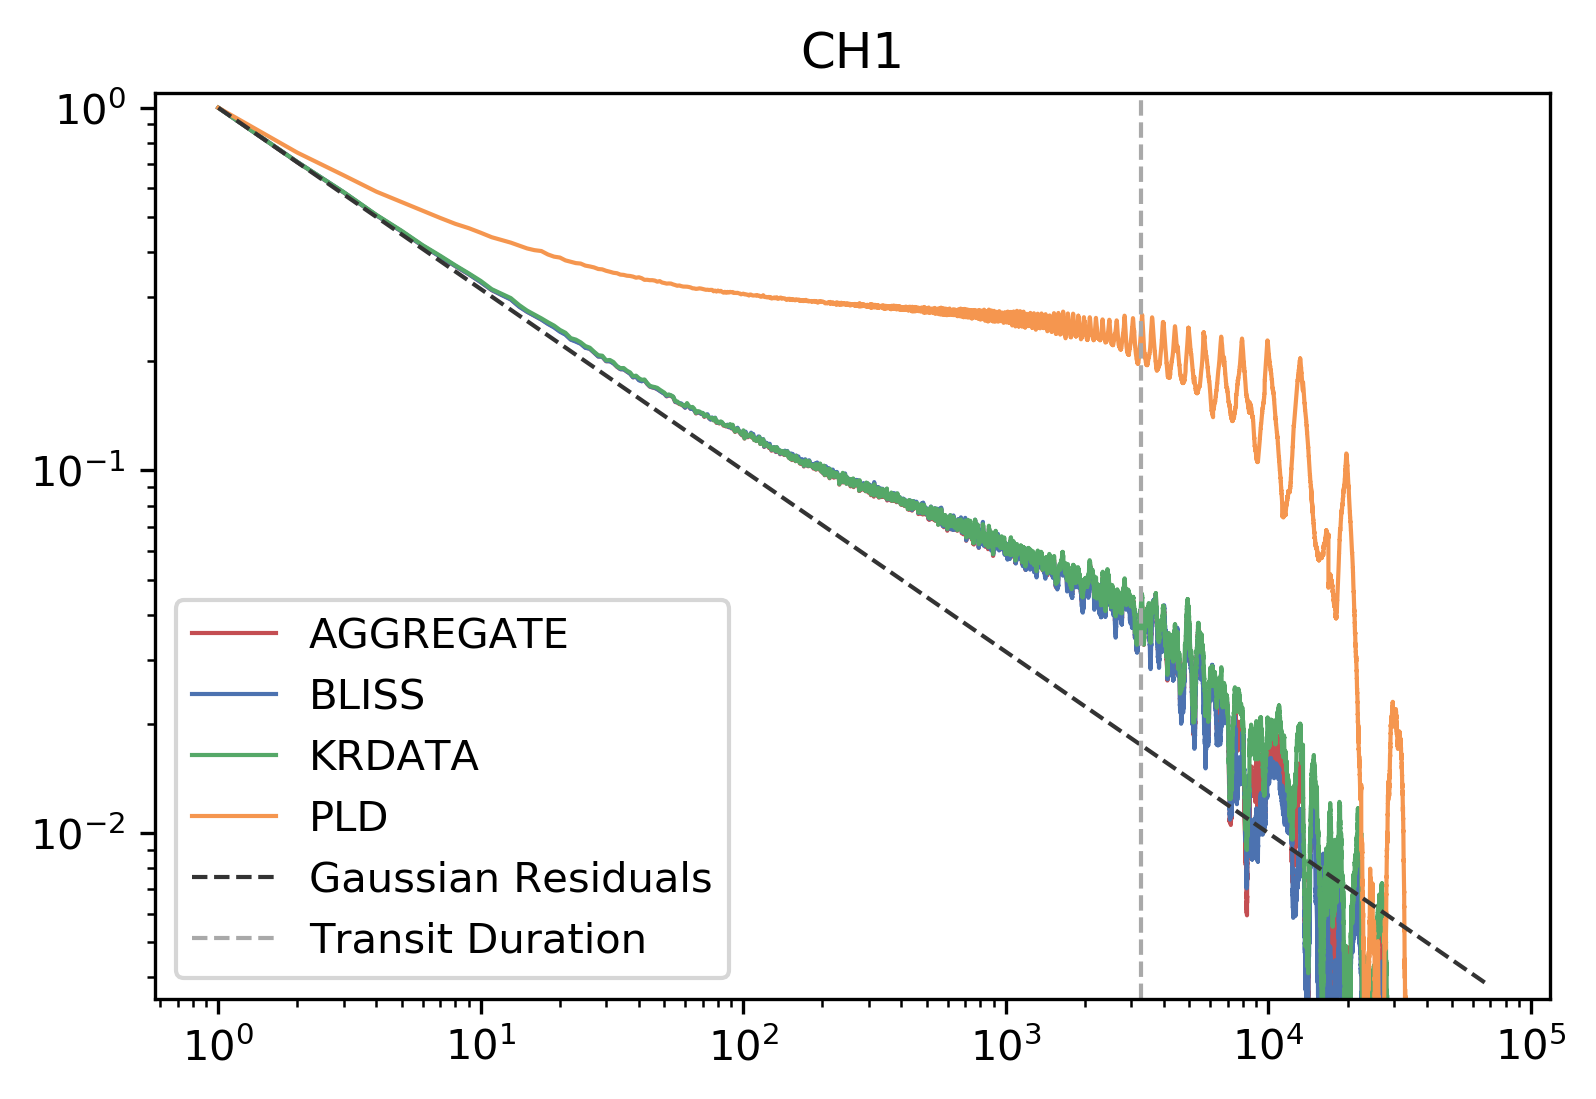

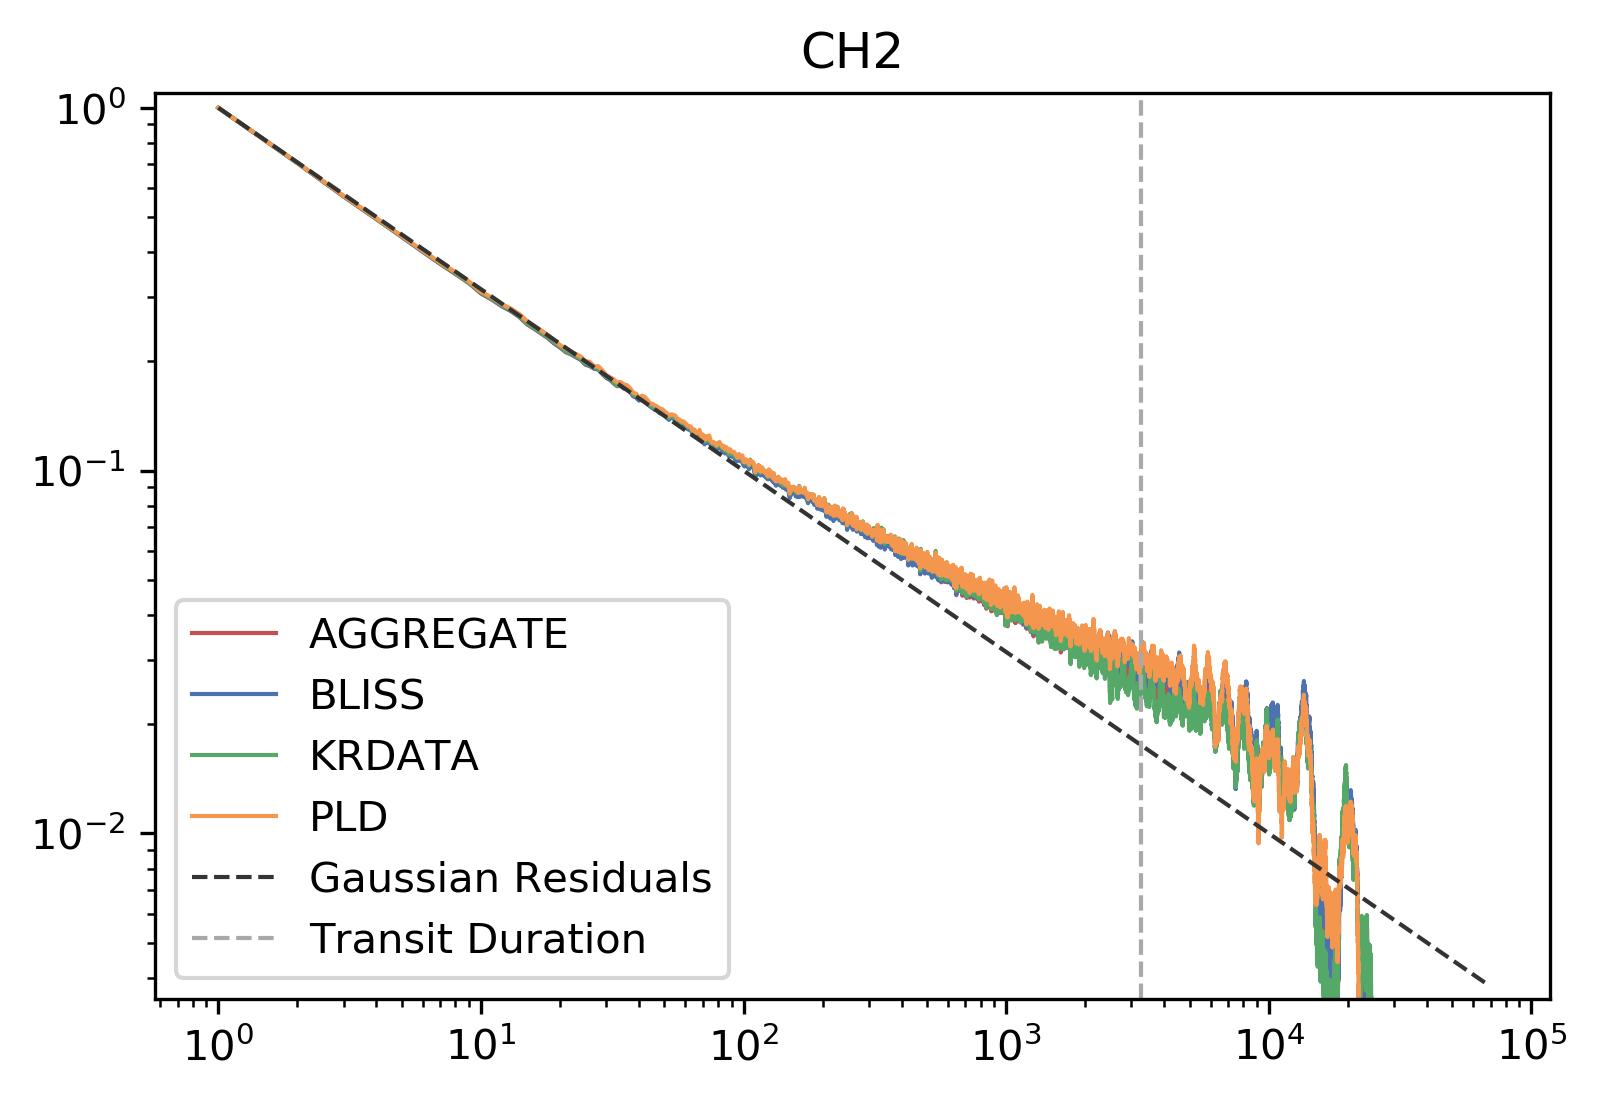

In [231]:
zorder = {}
zorder['aggregate'] = 100
zorder['bliss'] = 50
zorder['krdata'] = 20
zorder['pld'] = 10

alpha = 0.9

transit_duration = (planet_info.transit_duration) / np.median(np.diff(times[channel])) # in indices

save_now = True
for channel in rms_vs_binsize_set.keys():
    fig, ax = plt.subplots()
    ax.set_title(channel.upper())
    for method in sorted(rms_vs_binsize_set[channel].keys()):
        color = color_dict[method]
        model_rms_v_bs, bins_arr = rms_vs_binsize_set[channel][method]
        utils.plot_rms_vs_binsize(model_sets[channel][method], fluxes[channel], transit_duration=transit_duration,
                                  model_rms_v_bs=model_rms_v_bs, bins_arr=bins_arr, alpha=None,
                                  label=method.upper(), color=color, ax=ax, zorder=None);
    
    if save_now: 
        plot_save_name = '{}_{}_{}_{}_{}_all3_rms_vs_binsize.png'.format(planet_name.replace(' b','b'), channel, staticRad, varRad, 'mcmc')
        
        print('Saving Initial Fit Residuals Plot to {}'.format(save_dir + plot_save_name))
        fig.savefig(save_dir + plot_save_name)

# Plot the Physical Solutions to All Three Methods in Both Channels

In [106]:
thingy = list(mcmc_now_.params.values())[1]#, mcmc_now_.flatchain.shape
thingy.

<Parameter 'deltaTc', value=-0.002139176544775527 +/- 0.000471, bounds=[-0.025:0.025]>

In [ ]:
for channel, channel_stack in mcmc_stack.items():
    for method, mcmc_now_ in channel_stack.items():
        print(channel, method, mcmc_now_.params)

Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_bliss_mcmc_1000_1000_fit_residuals_physics_20190522081610.png
Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_krdata_mcmc_1000_1000_fit_residuals_physics_20190522081610.png
Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_pld_mcmc_1000_1000_fit_residuals_physics_20190522081610.png
Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch2_2.5_0.0_bliss_mcmc_1000_1000_fit_residuals_physics_20190522081610.png
Estab

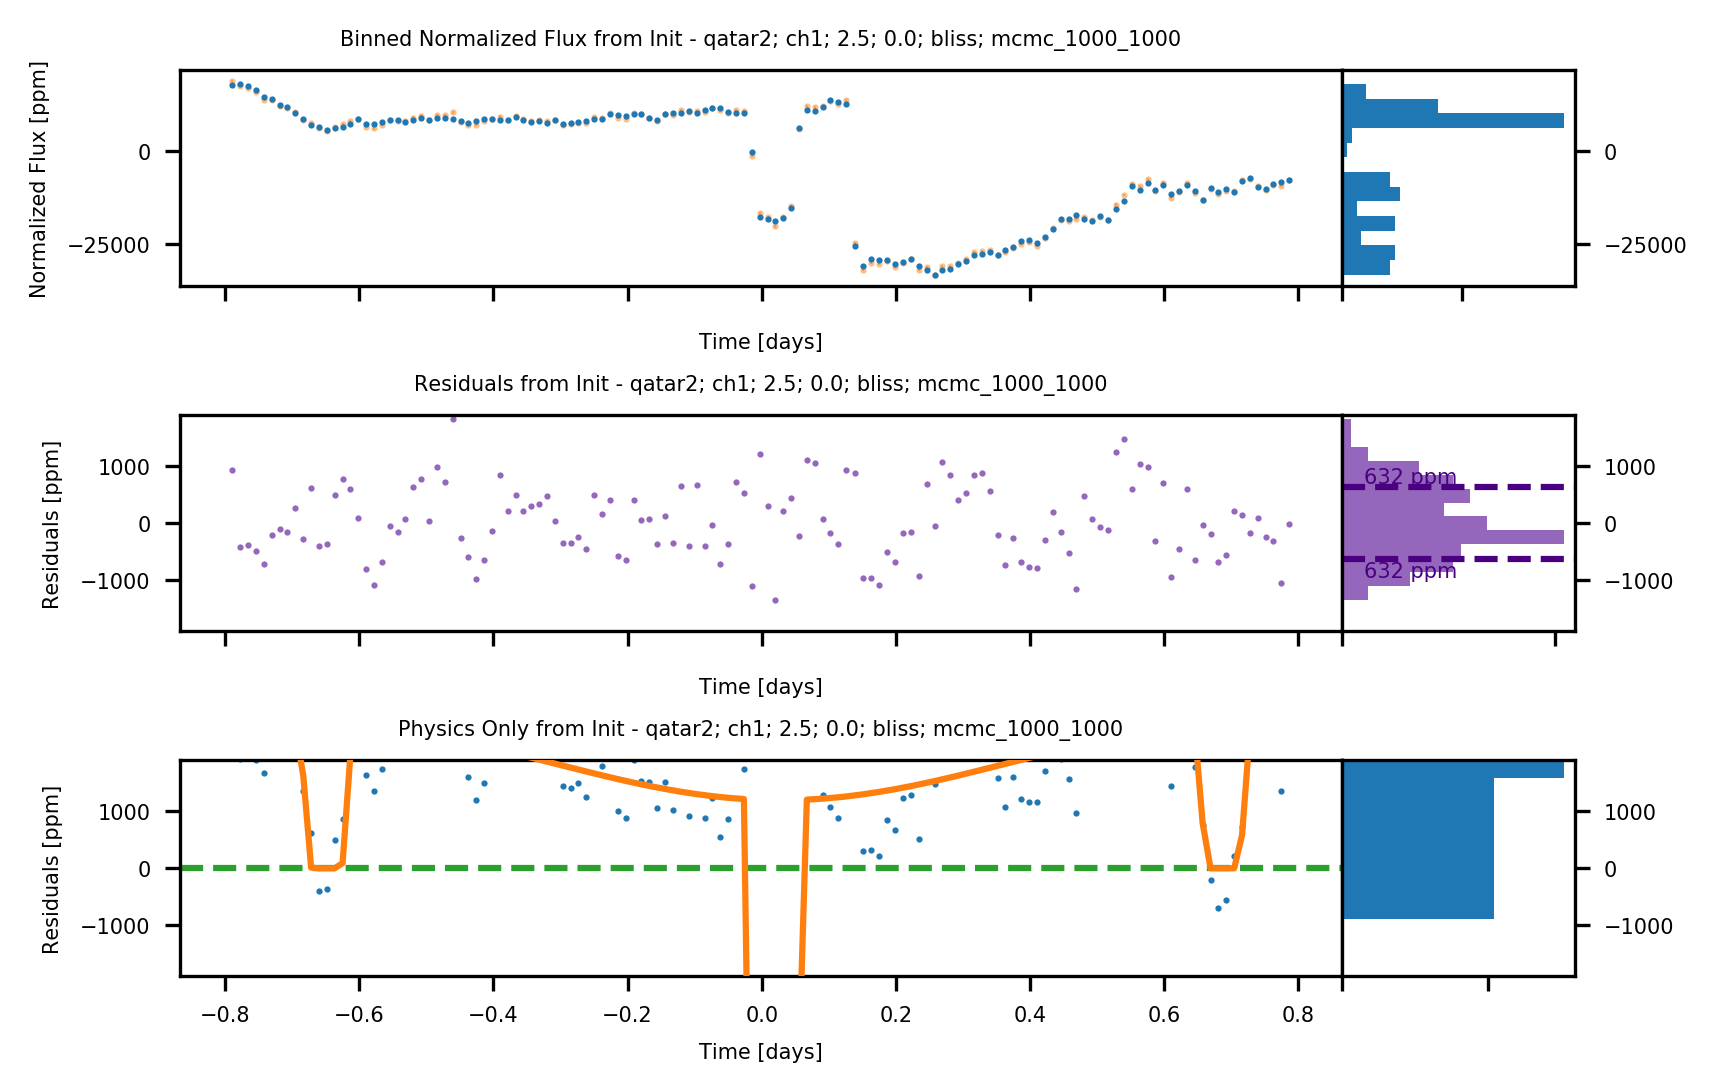

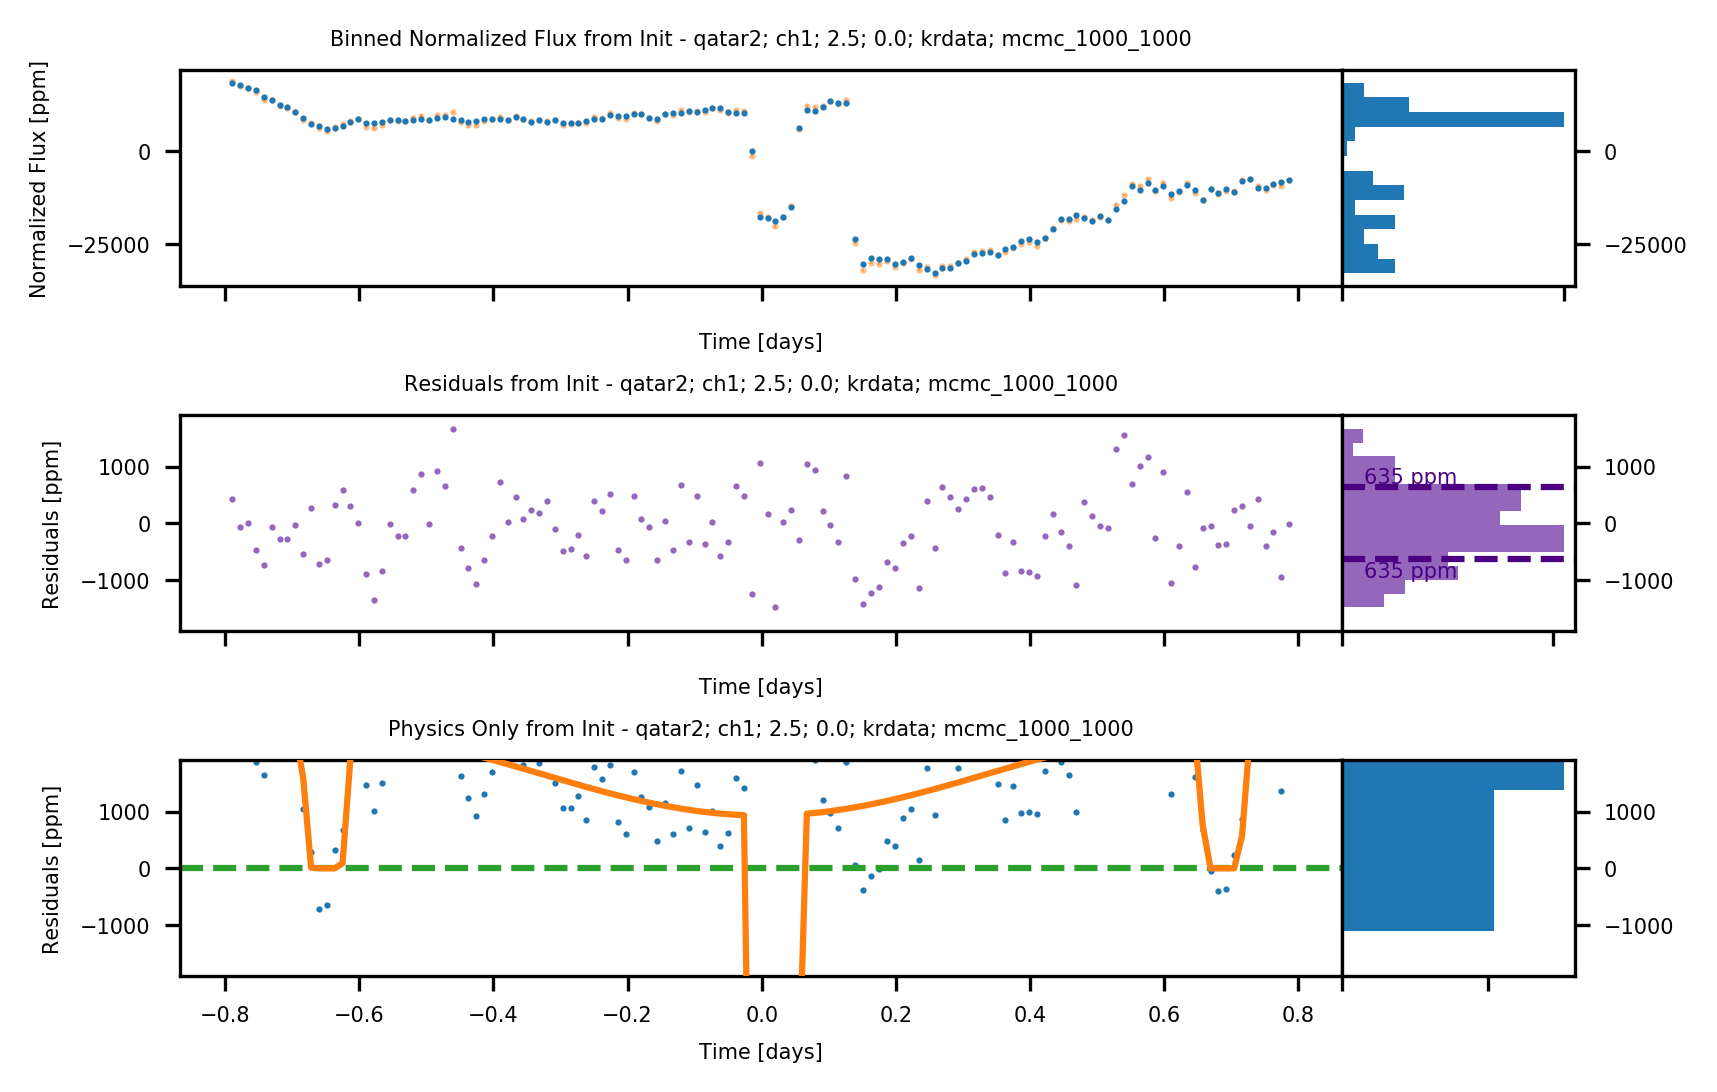

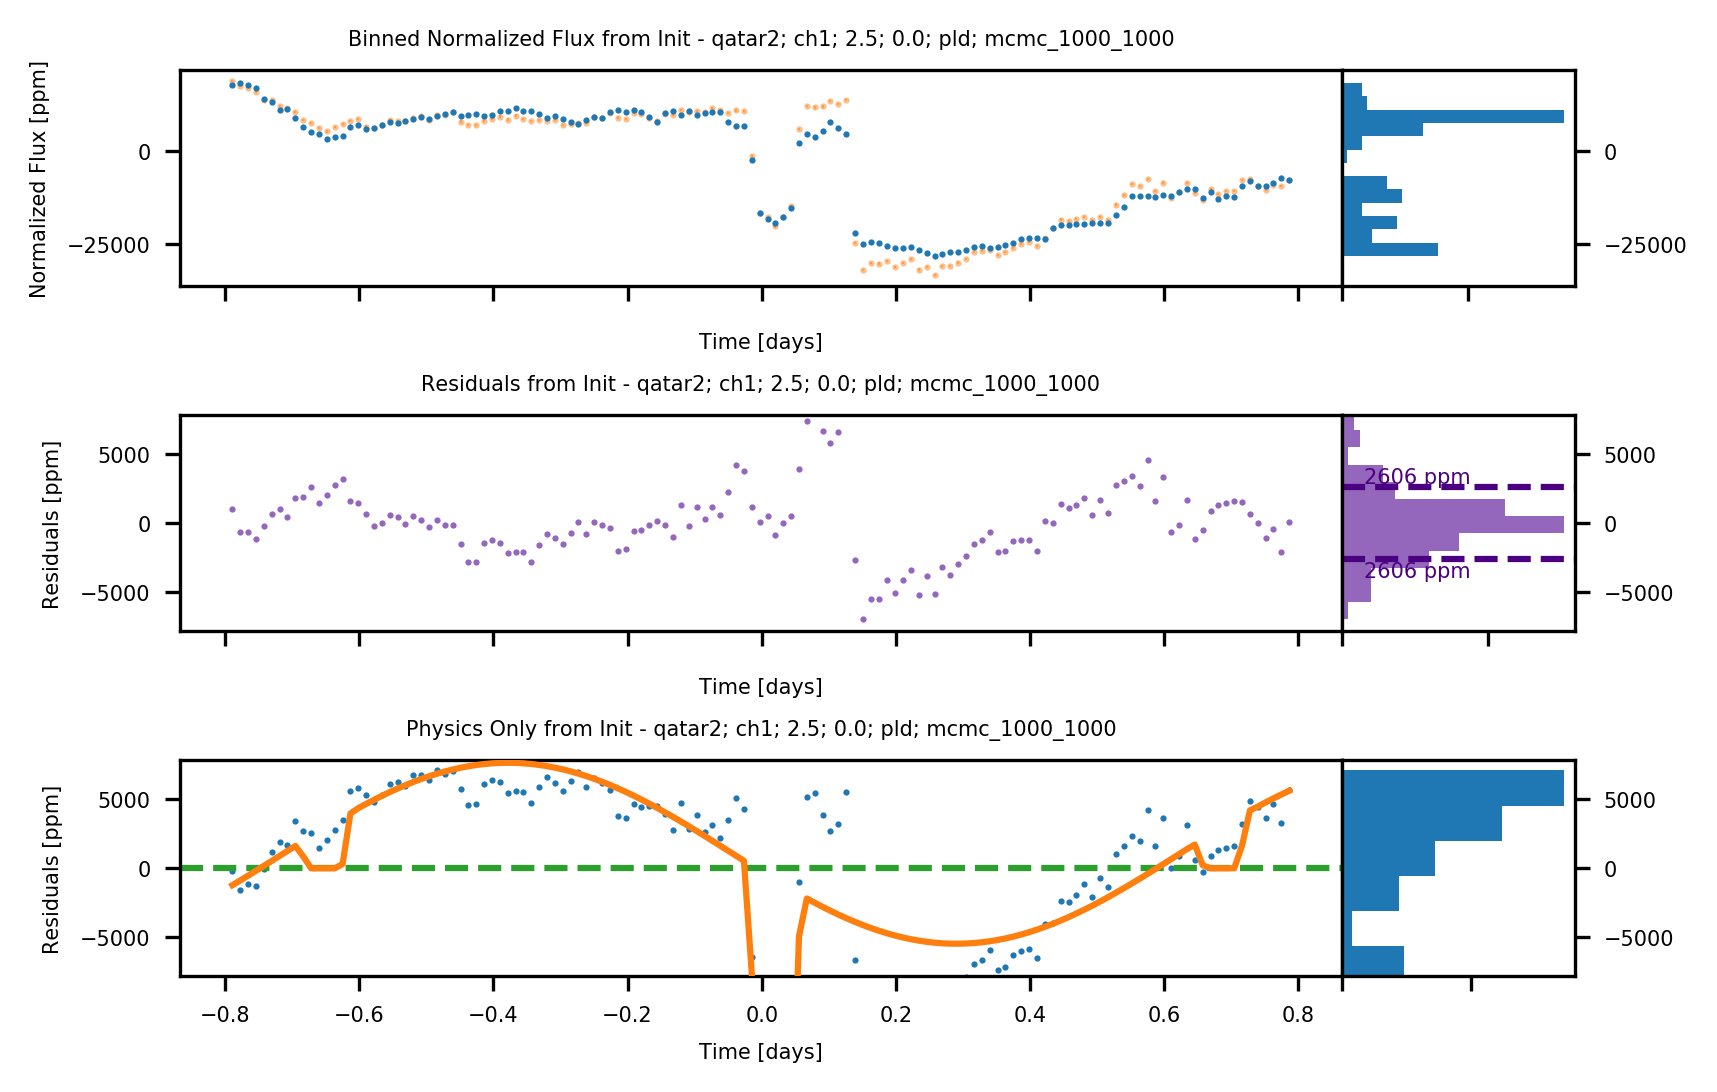

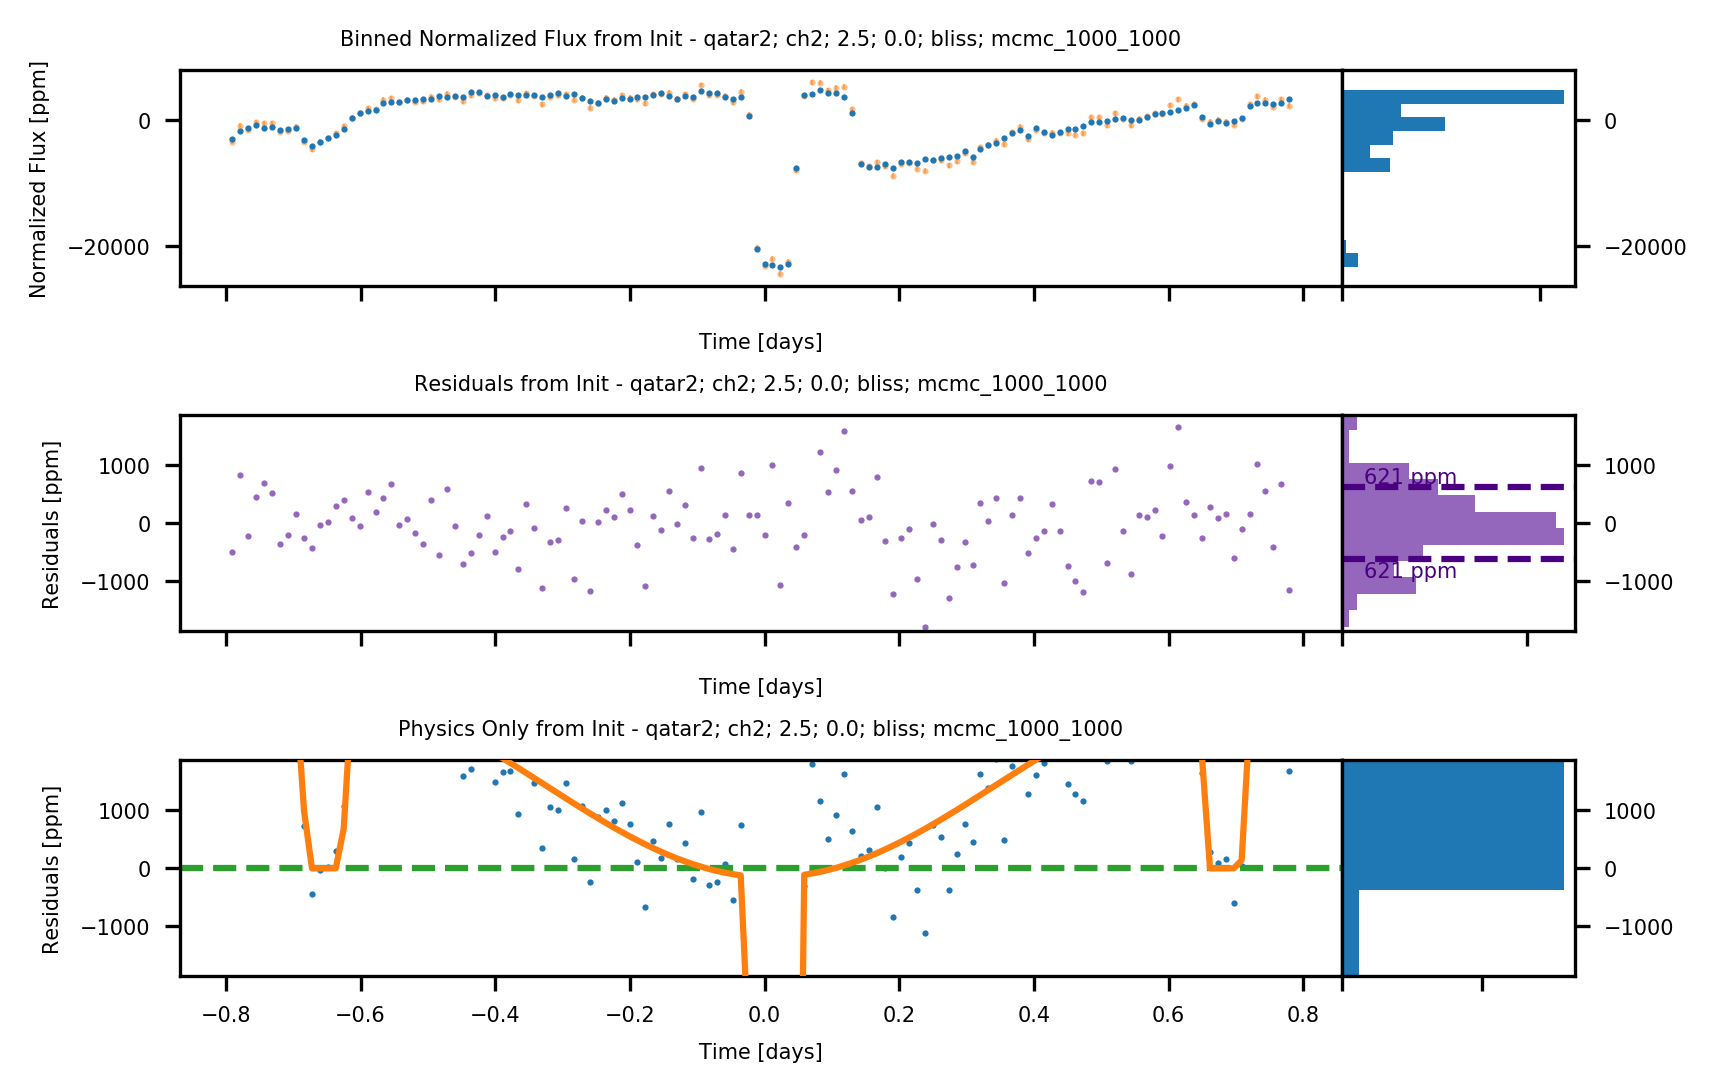

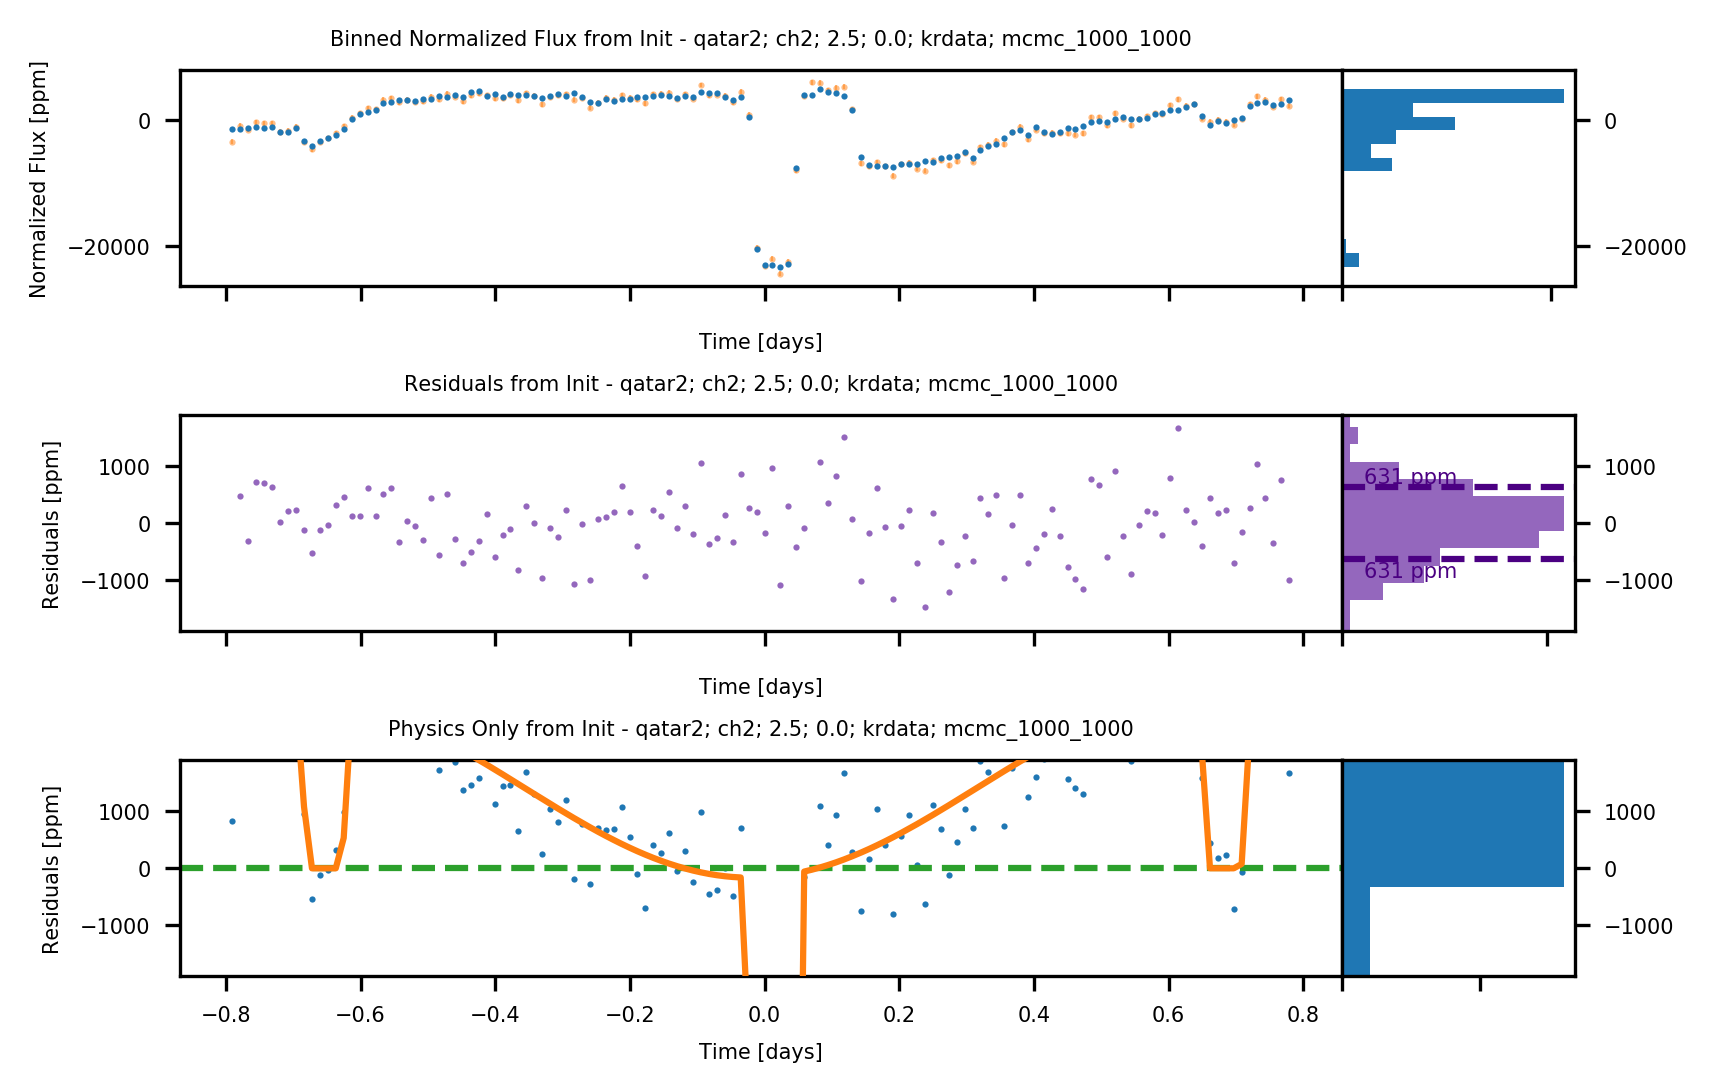

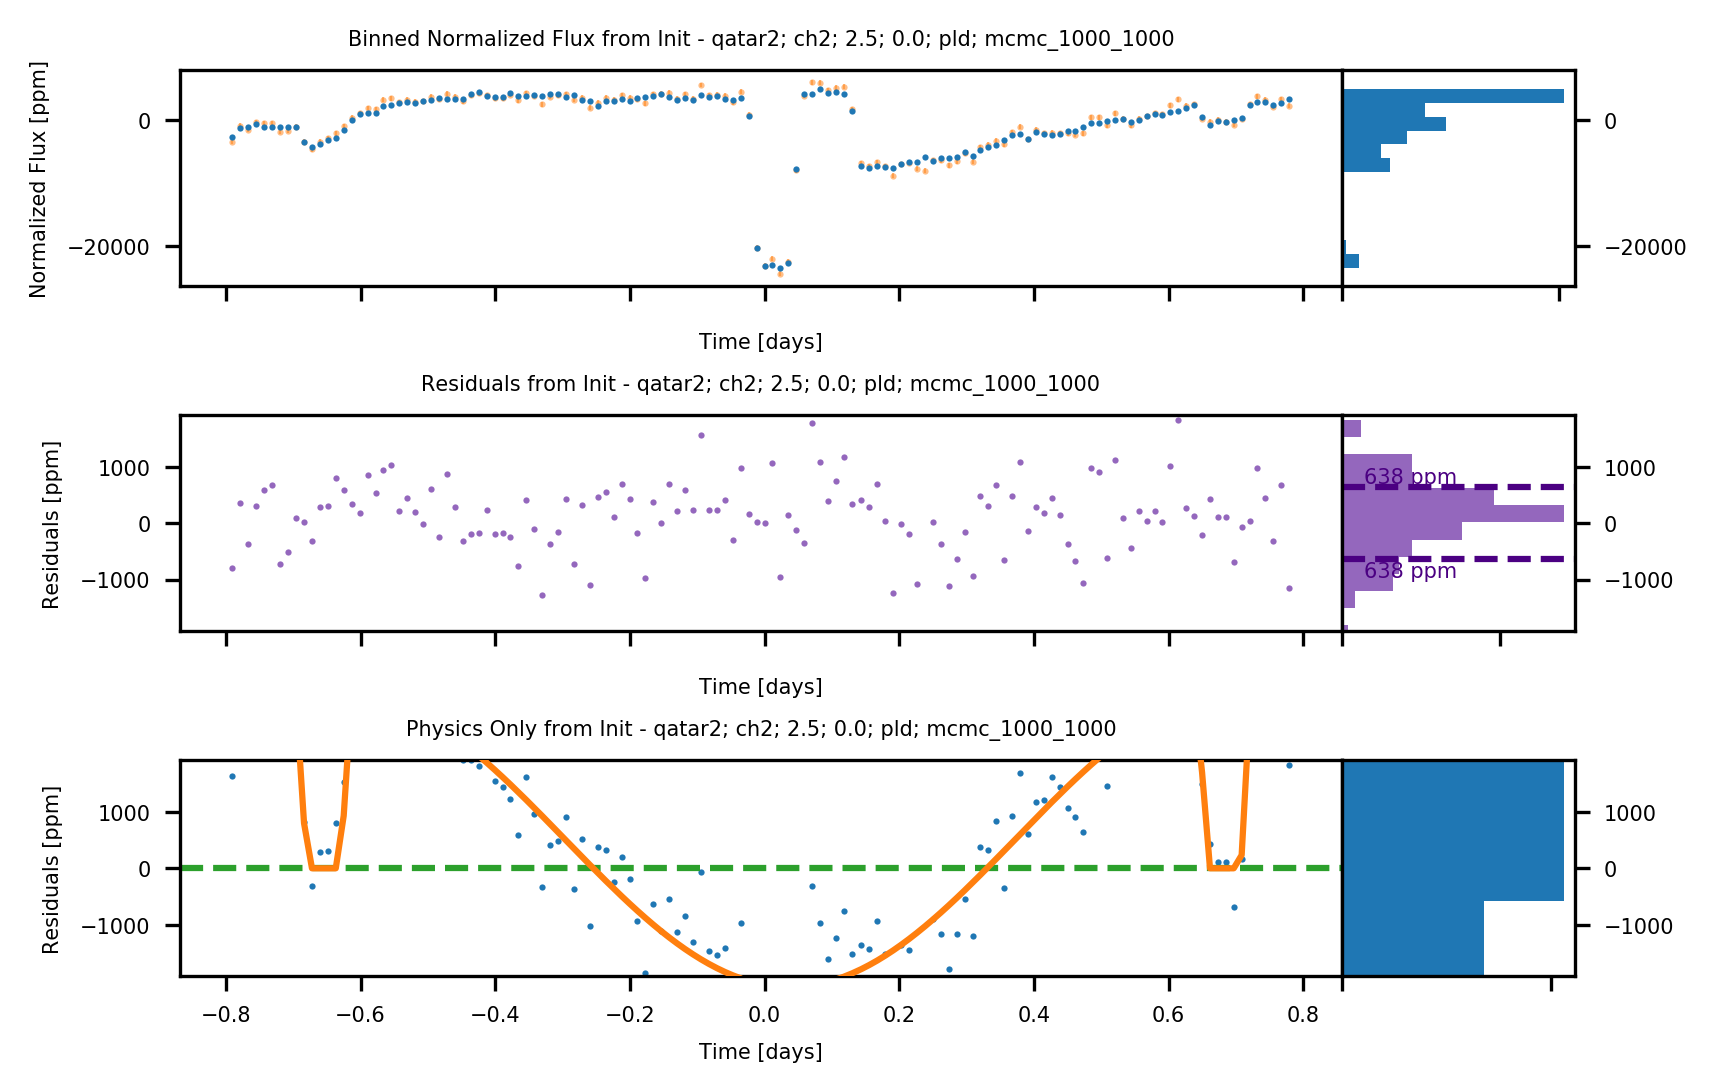

In [131]:
for channel, channel_stack in mcmc_stack.items():
    for method, mcmc_now_ in channel_stack.items():
        mcmc_model_set = skywalker.generate_best_fit_solution(  model_params = mcmc_now_.params, 
                                                            times = times[channel], 
                                                            xcenters = xcenters[channel], 
                                                            ycenters = ycenters[channel], 
                                                            fluxes = fluxes[channel], 
                                                            knots = knots[channel][method], 
                                                            keep_inds = keep_inds[channel], 
                                                            planet_info = planet_info,
                                                            method = method, 
                                                            nearIndices = nearIndices[channel][method], 
                                                            ind_kdtree = ind_kdtree[channel][method], 
                                                            gw_kdtree = gw_kdtree[channel][method], 
                                                            pld_intensities = pld_intensities[channel][method], 
                                                            x_bin_size = x_bin_size, 
                                                            y_bin_size = y_bin_size)

        bin_size = 500
        plot_name = 'mcmc_{}_{}'.format(n_steps, n_walkers)
        plot_fit_residuals_physics(times[channel], fluxes[channel], flux_errs[channel], mcmc_model_set, plot_name=plot_name,planet_name=planet_name, 
                                   channel=channel, staticRad=staticRad, varRad=varRad, method=method, bin_size=bin_size,
                                   time_stamp=time_stamp, save_now=True, save_dir=save_dir, markersize=3)

Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_bliss_mcmc_1000_1000_physics_only_20190522081610.jpeg
Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_krdata_mcmc_1000_1000_physics_only_20190522081610.jpeg
Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch1_2.5_0.0_pld_mcmc_1000_1000_physics_only_20190522081610.jpeg
Establishing the mcmc_1000_1000 Solution
Saving Initial Fit Residuals Plot to /Users/jonathan/Research/Planets/PhaseCurves/Qatar2_Results/STARRY_Runs/Copy_for_Plotting/qatar2_ch2_2.5_0.0_bliss_mcmc_1000_1000_physics_only_20190522081610.jpeg
Establishing the mcmc_1000_1000 Solut

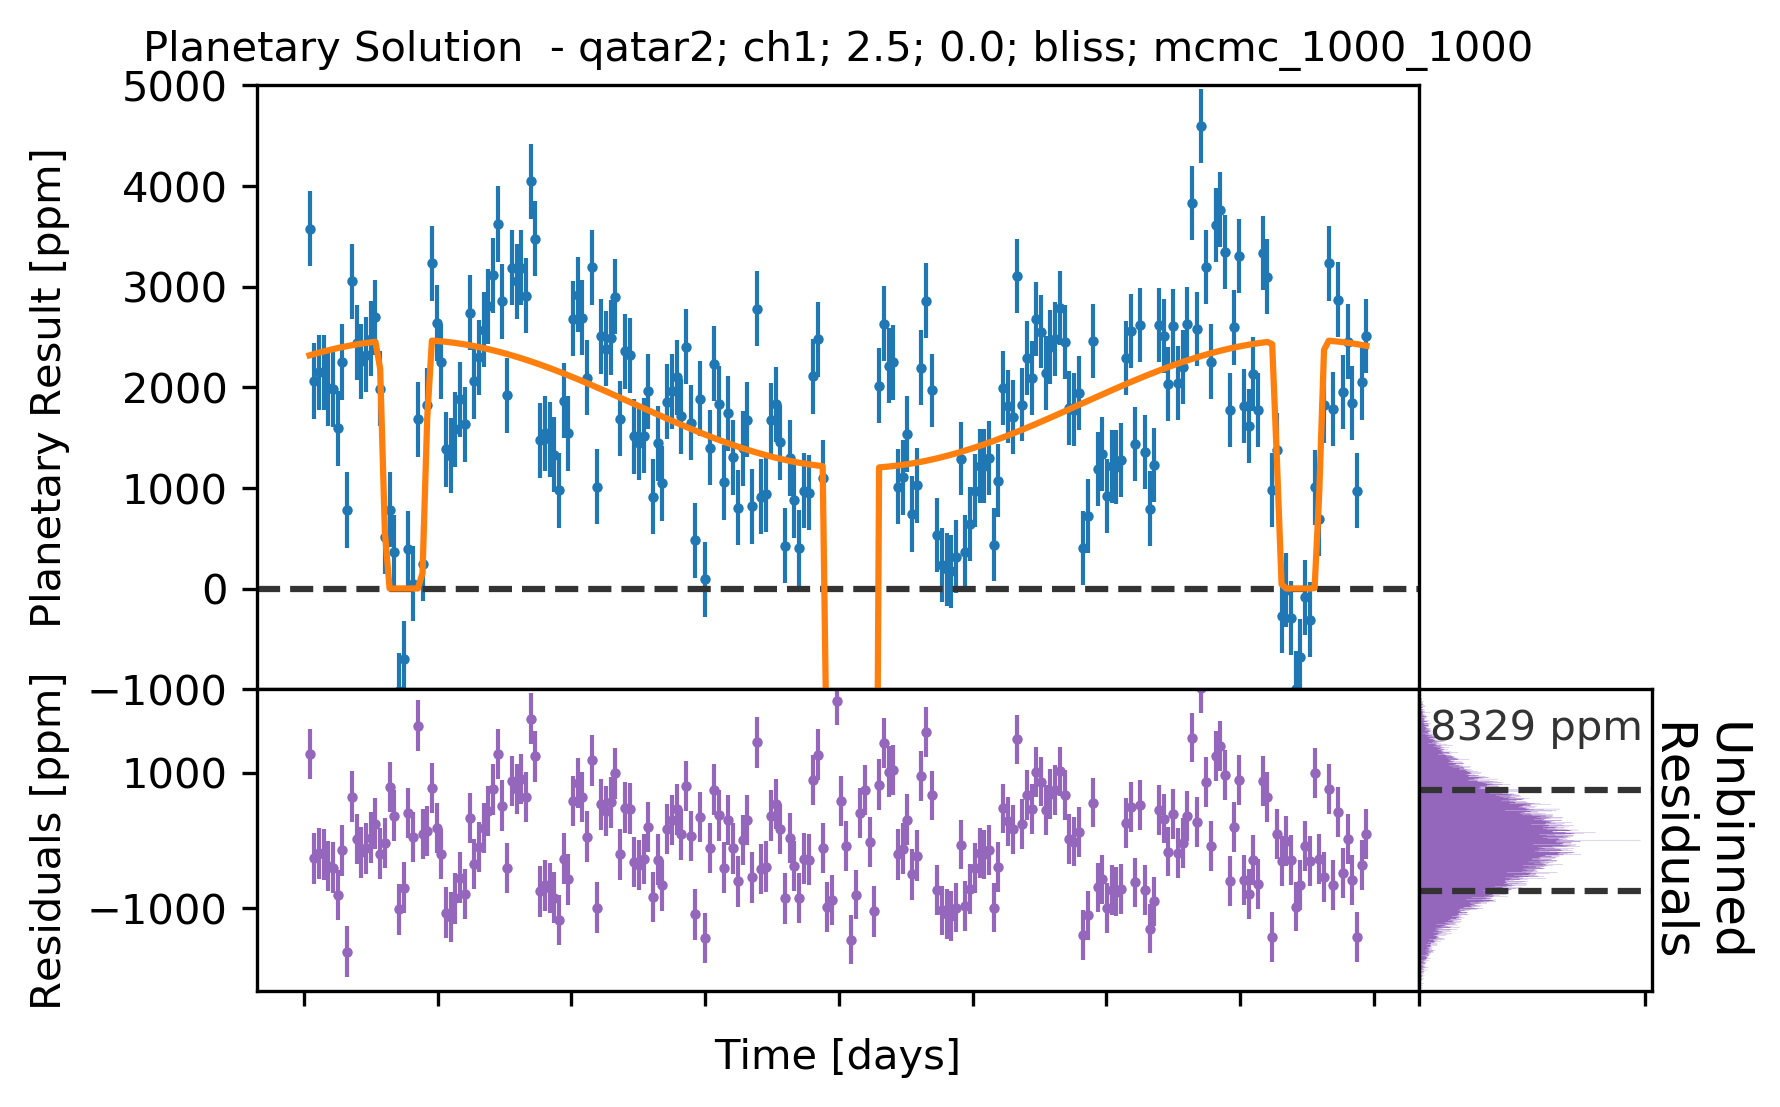

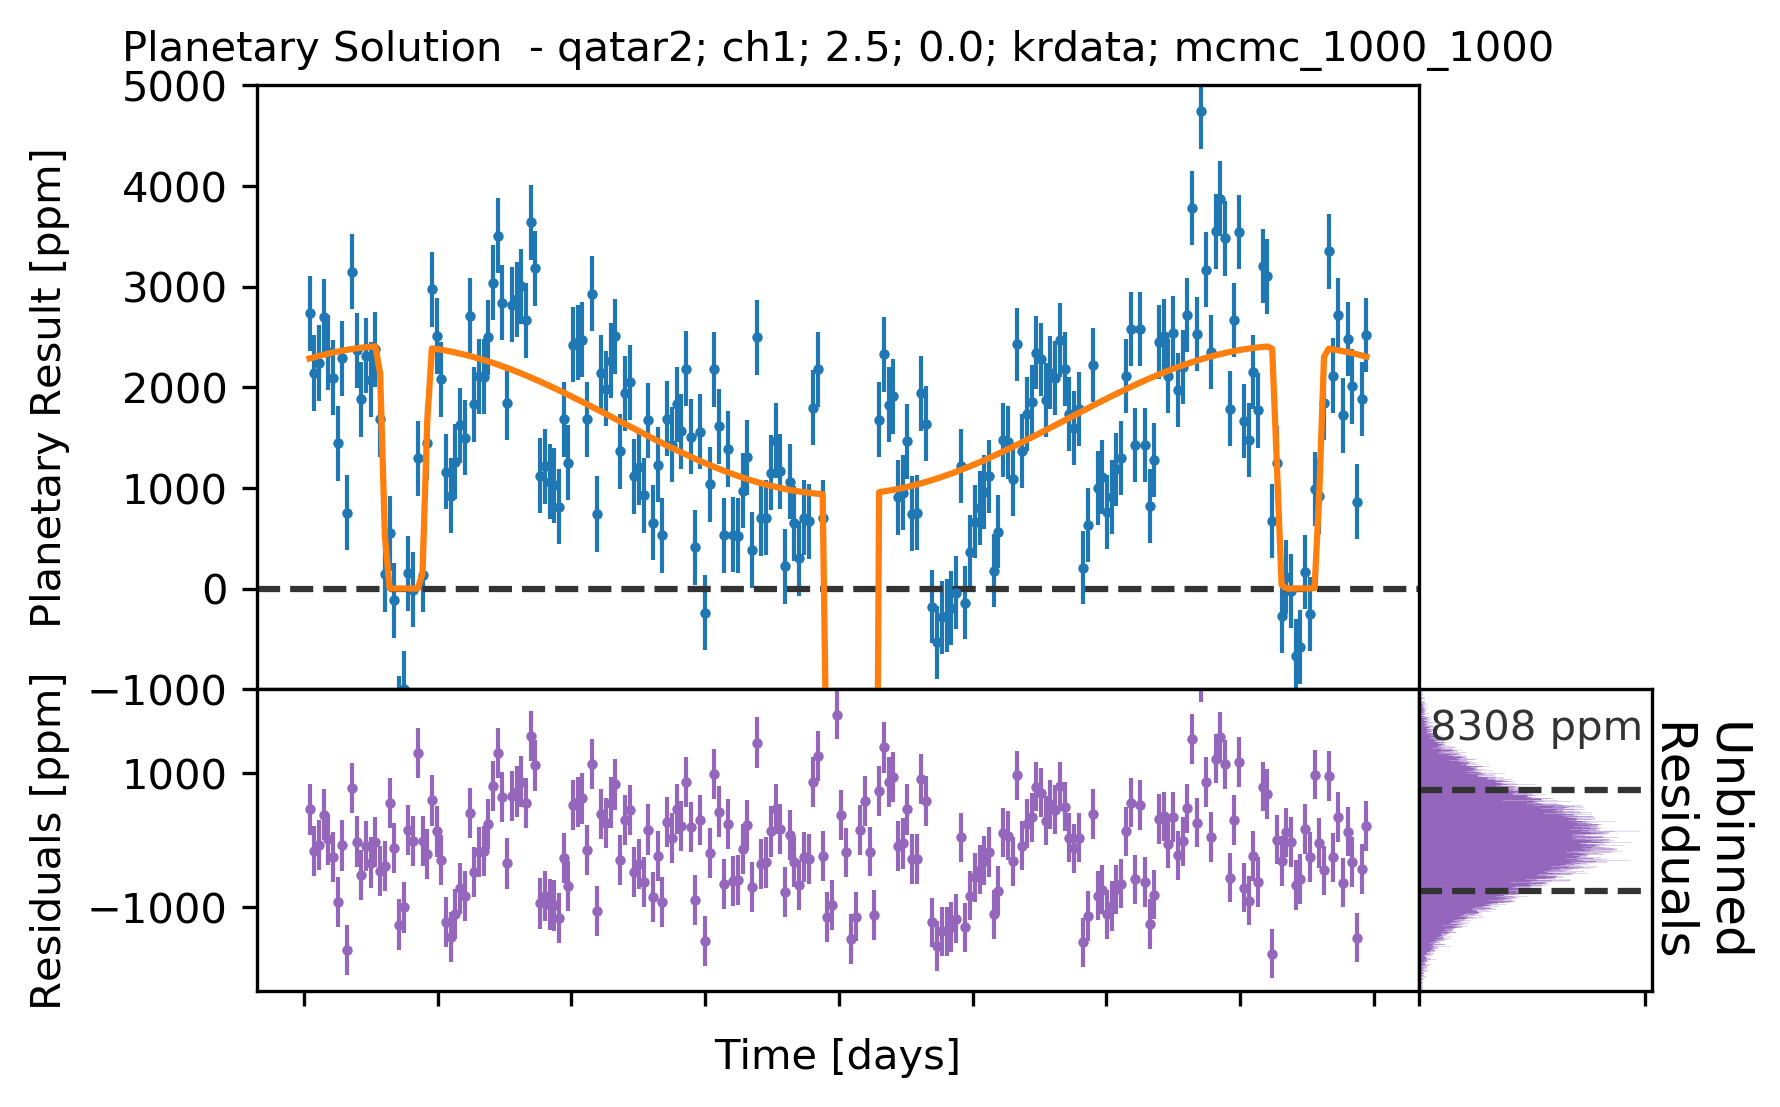

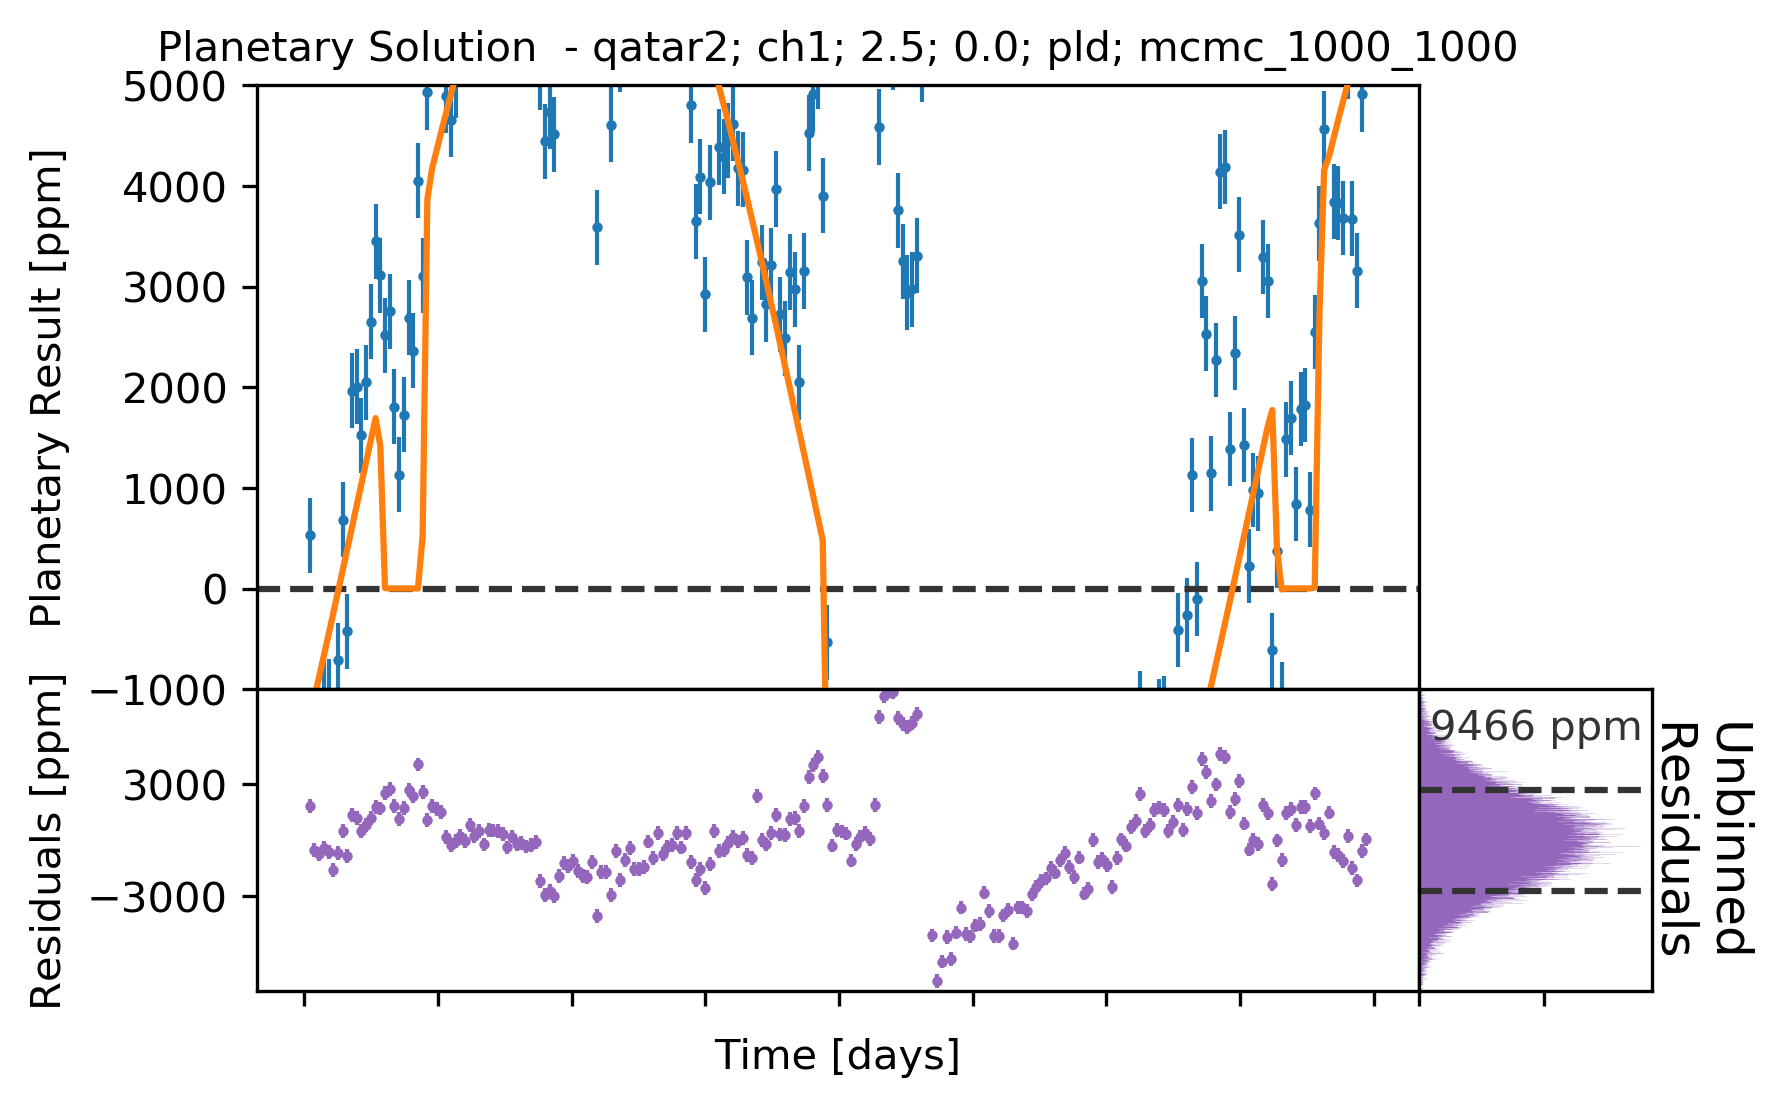

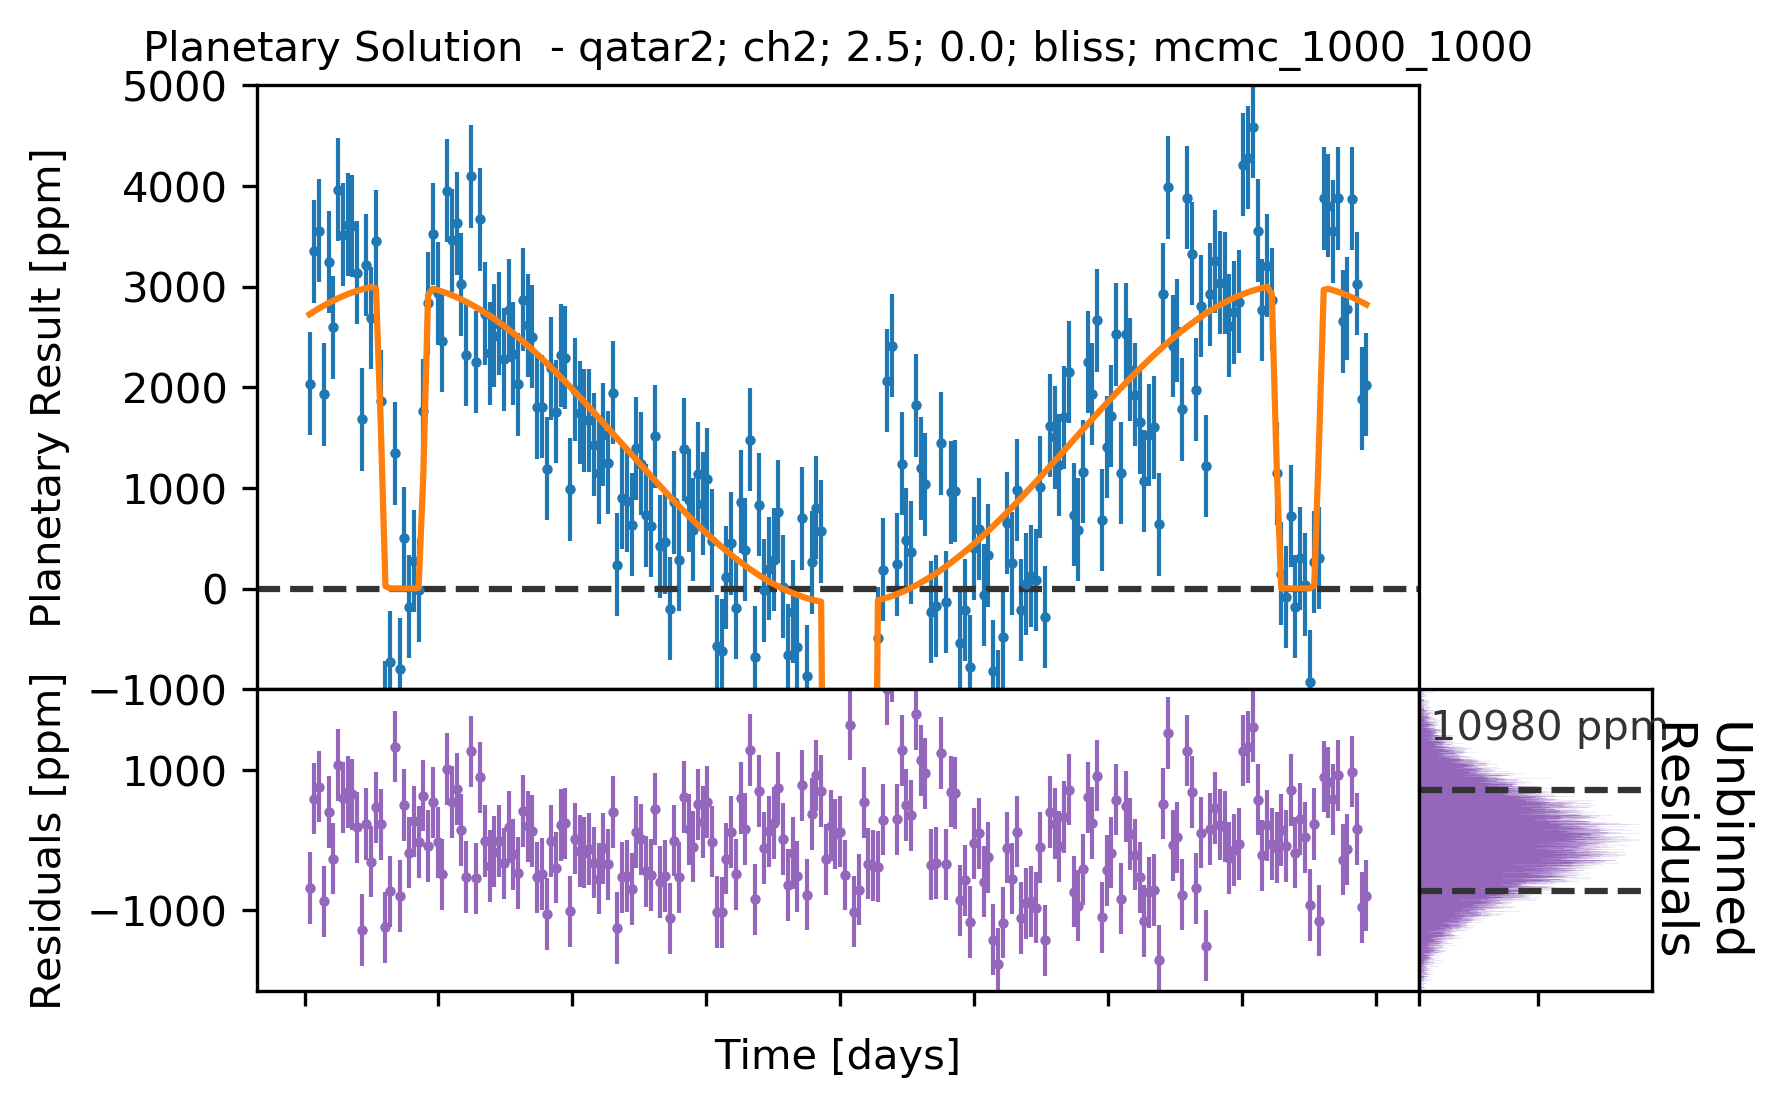

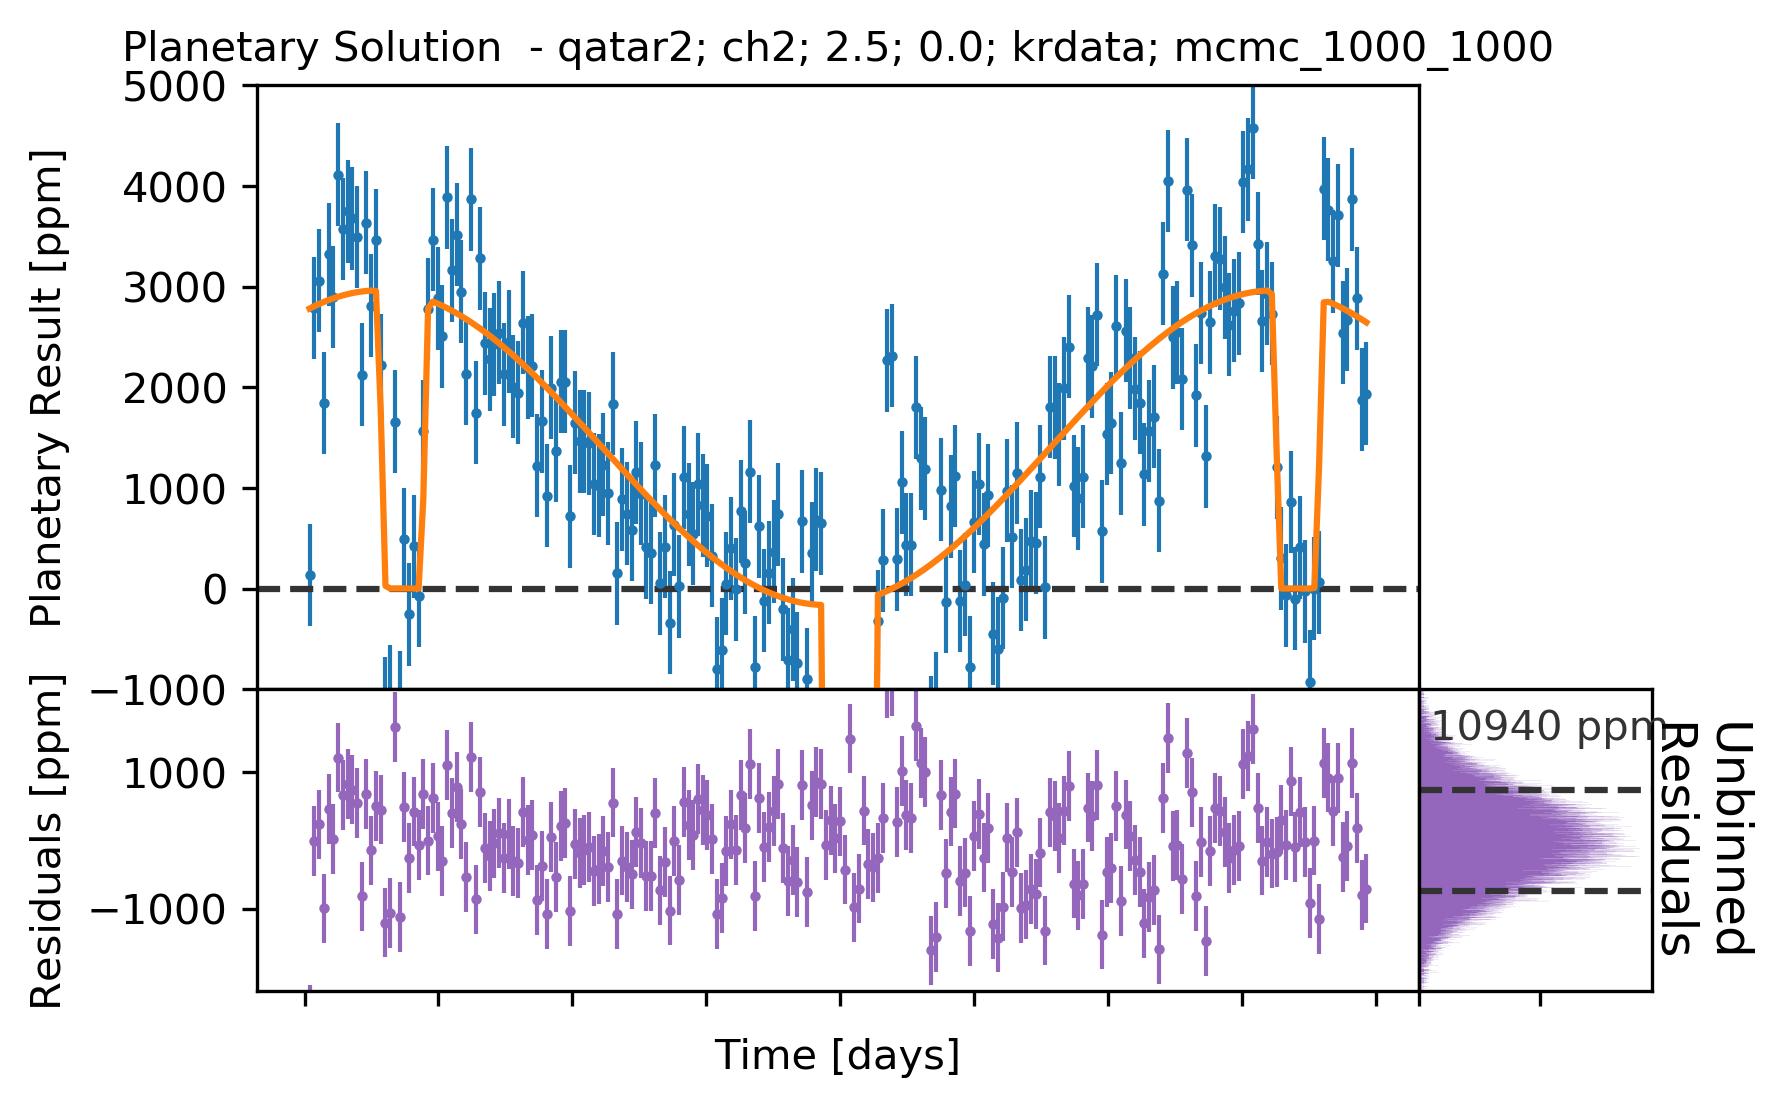

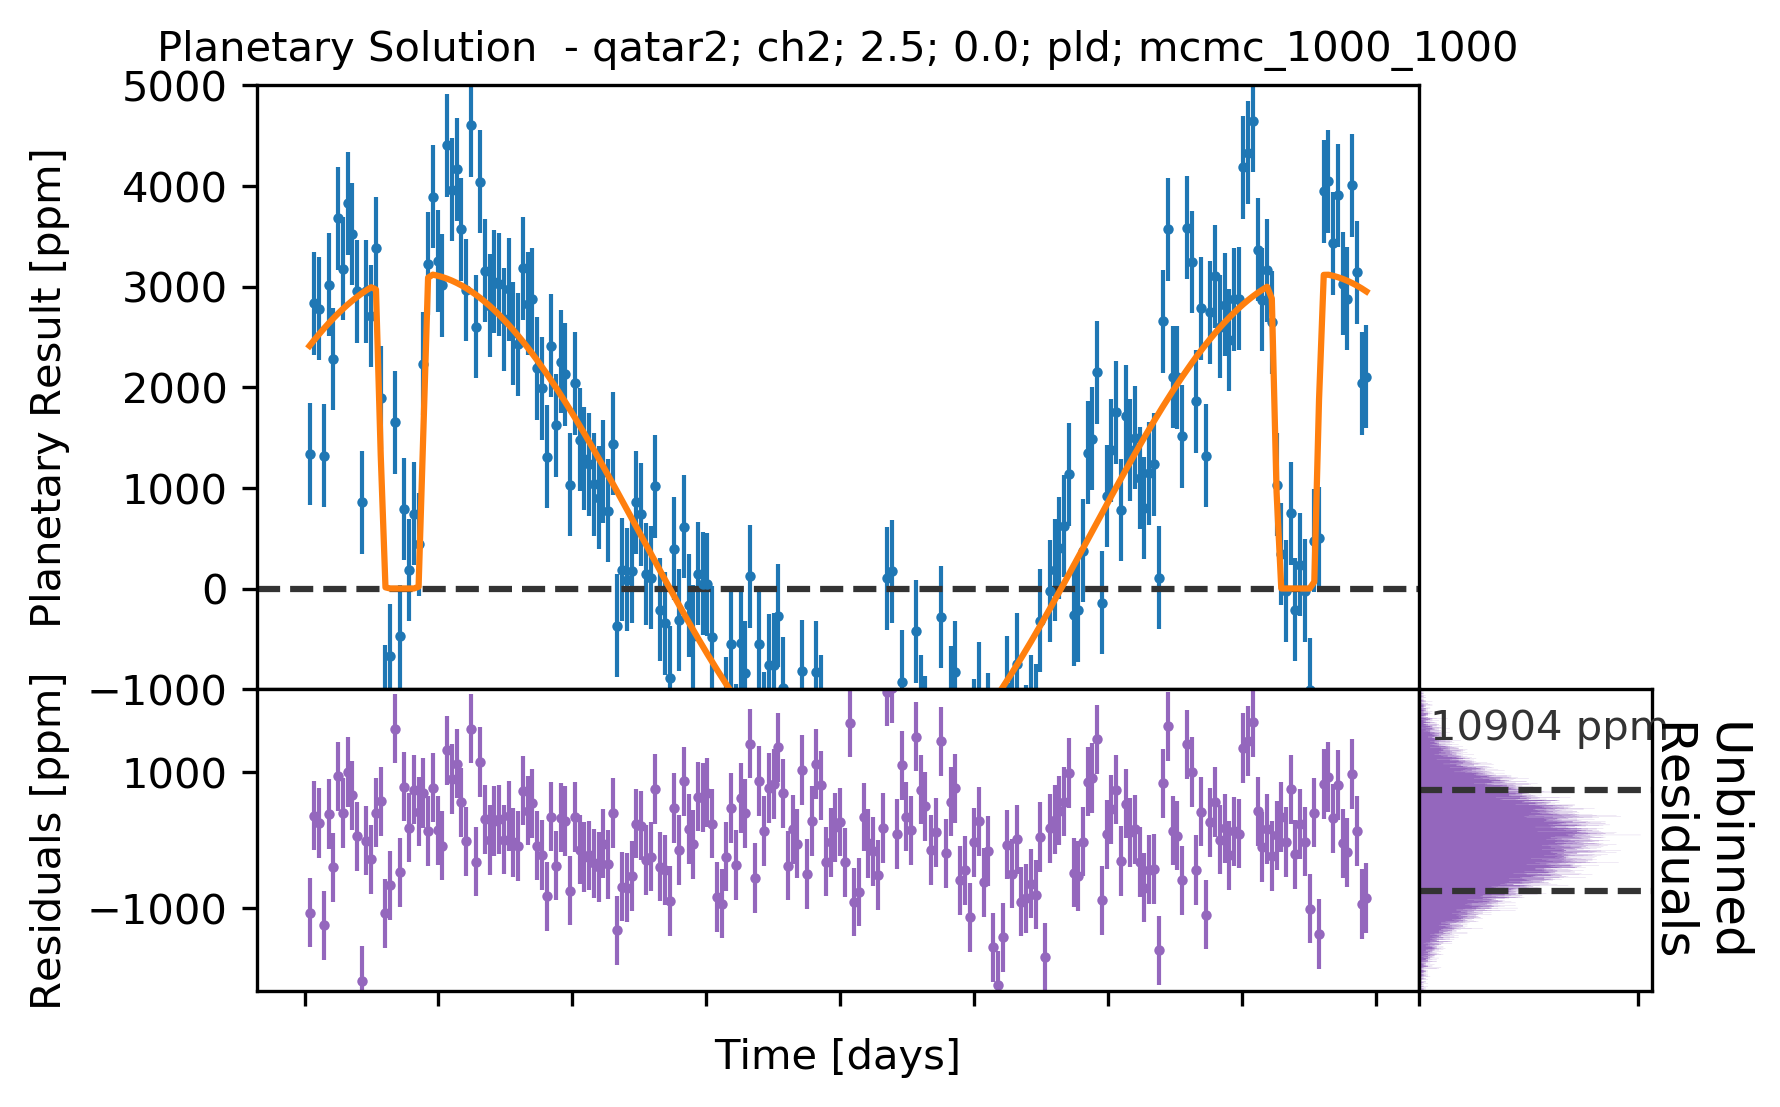

In [222]:

for channel, channel_stack in mcmc_stack.items():#zip(['ch1'], [mcmc_stack['ch1']]):#
    for method, mcmc_now_ in channel_stack.items():#zip(['bliss'], [mcmc_stack['ch1']['bliss']]):#
        mcmc_model_set = skywalker.generate_best_fit_solution(  model_params = mcmc_now_.params, 
                                                            times = times[channel], 
                                                            xcenters = xcenters[channel], 
                                                            ycenters = ycenters[channel], 
                                                            fluxes = fluxes[channel], 
                                                            knots = knots[channel][method], 
                                                            keep_inds = keep_inds[channel], 
                                                            planet_info = planet_info,
                                                            method = method, 
                                                            nearIndices = nearIndices[channel][method], 
                                                            ind_kdtree = ind_kdtree[channel][method], 
                                                            gw_kdtree = gw_kdtree[channel][method], 
                                                            pld_intensities = pld_intensities[channel][method], 
                                                            x_bin_size = x_bin_size, 
                                                            y_bin_size = y_bin_size)

        bin_size = 300
        plot_name = 'mcmc_{}_{}'.format(n_steps, n_walkers)
        plot_physics_only(times[channel], fluxes[channel], flux_errs[channel], mcmc_model_set, plot_name=plot_name,planet_name=planet_name, 
                                   channel=channel, staticRad=staticRad, varRad=varRad, method=method, bin_size=bin_size, nSig=3,
                                   time_stamp=time_stamp, save_now=True, save_dir=save_dir, markersize=5, phys_ylim=[-1000,5000])#[-50000,20000]

# OLD PLOTS

# Plot Individual Channels and Methods